In [96]:
from astropy.io import fits
from astropy.convolution import Gaussian2DKernel, convolve_fft
import numpy as np
from regions import Regions
import astropy.io.fits as pyfits
import os
import matplotlib
from reproject import reproject_interp
from scipy import ndimage, misc
from astropy.wcs import WCS
import pyregion
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.convolution import Gaussian2DKernel
from scipy.signal import convolve as scipy_convolve
from astropy.convolution import convolve_fft
from scipy import ndimage, misc
from matplotlib.colors import LogNorm
from astropy.nddata import Cutout2D
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import matplotlib.patheffects as pe
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import curve_fit
import skimage as ski
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.axes as maxes
from skimage.draw import polygon2mask
import skimage.measure as measure
matplotlib.pyplot.rcParams.update({'text.usetex' : True})
matplotlib.rcParams['font.sans-serif'] = "georgia" 

In [92]:
def open_files(file):
    filename = file
    hdu  = fits.open(filename)[0]
    wcs=WCS(hdu.header)
    if hdu.header['NAXIS']==3:
        wcs=wcs.dropaxis(2)
    return hdu, wcs

def fig(file,row,col):
    mpl.rcParams['font.sans-serif'] = "georgia"
    mpl.rcParams['mathtext.fontset'] = "cm" 
    hdu,wcs=file                                            #unpacking file

    fig = plt.figure(figsize=(16, 6))
    for i in range(row * col):
        coord = plt.subplot(row, col, i + 1, projection=wcs, slices=('x', 'y'))
        lon = coord.coords[0]
        lat = coord.coords[1]

        return coord.imshow(hdu.data,norm='log')


def plot_coords_galactic(file, min_coord, max_coord): 
    hdu,wcs=file  
    min_galactic = SkyCoord(frame="galactic", l=min_coord[0] , b=min_coord[1], unit=(u.deg)) #found on simbad
    min_pixel = wcs.world_to_pixel(min_galactic)

    max_galactic = SkyCoord(frame="galactic", l=max_coord[0] , b=max_coord[1], unit=(u.deg)) #found on simbad
    max_pixel = wcs.world_to_pixel(max_galactic)

    return min_pixel,max_pixel

def single_coord(file,coord):
    hdu,wcs=file 
    pos = SkyCoord(frame="galactic", l=coord[0], b=coord[1], unit=(u.deg))
    x, y = wcs.world_to_pixel(pos)
    return (x, y)
def median_flux(file):
    hdu,wcs=file
    region_filename = 'data/Terrier_2018_all.reg'
    regions = read_ds9(region_filename)
    mask = np.zeros(hdu.data.shape, dtype=bool)
    for i in range((12)):
        pixel_region = regions[i].to_pixel(wcs)
        if pixel_region.to_mask(mode='center').to_image(hdu.shape) is not None:
            mask |= pixel_region.to_mask(mode='center').to_image(hdu.shape).astype(bool)
    result = np.ma.masked_array(hdu.data, mask)
    med_flux=np.nanmedian(result)
    return med_flux

def is_regions_file(file_path):
    # Get the file extension
    _, file_extension = os.path.splitext(file_path)
    
    # Check if the extension is .reg
    if file_extension.lower() == '.reg':
        return True
    else:
        return False

def crop(filename, min_coords,max_coords, output_filename):
    file = open_files(filename)
    hdu, wcs = file

    pixel_min= single_coord(file,min_coords)
    pixel_max=single_coord(file,max_coords)
    pixel_width=np.abs(pixel_max[0]-pixel_min[0])
    pixel_length=np.abs(pixel_max[1]-pixel_min[1])
    pixel_center= [pixel_min[0]+(pixel_max[0]-pixel_min[0])/2,pixel_min[1]+(pixel_max[1]-pixel_min[1])/2]

    cutout          = Cutout2D(hdu.data, position=[pixel_center[0], pixel_center[1]],
                    size=(pixel_length,pixel_width), wcs=wcs)
    hdu.data        = cutout.data
    hdu.header.update(cutout.wcs.to_header())
    hdu.writeto(output_filename, overwrite=True)

def parabola(x, a, b):
    return a * (x ** 2) + b 

# Function to overwrite sub_dict completely based on selected regions
def overwrite_sub_dict(selected_names):
    # Overwrite the entire sub_dict
    return {name: cloud_dict[name] for name in selected_names if name in cloud_dict}

In [93]:
from astropy.io import fits
import numpy as np

class Person:
    def __init__(self, sub_dict, selected_names=None):
        """
        Takes in a dictionary of names and ellipse regions
        region: List of regions (e.g., read from a file or passed as a parameter)
        name: List of region names corresponding to each region
        selected_names: List of names to filter regions
        """
        self.region = []
        self.name = []
        
        if selected_names:
            for name in selected_names:
                if name in sub_dict:
                    self.region.append(sub_dict[name])
                    self.name.append(name)
        else:
            self.region = list(sub_dict.values())
            self.name = list(sub_dict.keys())

class IndividualMasks(Person):
    def reproject_and_save(self, file, output_filename_template,array=None,wcs_array=None,split=False,slices=False):
        """
        Reprojects the mask, applies it to the data, and saves the masked FITS file for each region.

        Parameters:
        file: str
            Filename for the background file.
        output_filename_template: str
            Template for saving the masked FITS file (should include a placeholder for the region name).
        """
        # Open and unpack the FITS file
        file_data = open_files(file)
        hdu_file, wcs_file = file_data

        # Loop over each region
        for name, region in zip(self.name, self.region):
            if type(region)=='regions.core.regions.Regions':     #if file passed through is a Regions file
                # Convert the region to pixel coordinates
                pixel_region = region.to_pixel(wcs_file)
                
                # Create the mask for the region
                mask_filled = pixel_region.to_mask(mode='center').to_image(hdu_file.data.shape)
            else:                                                       #if an array is passed for the mask shape
                array_wcs_tuple=region
                print(type(array_wcs_tuple))
                result_reproj, _ = reproject_interp(array_wcs_tuple, wcs_file, shape_out=hdu_file.data.shape)
                mask_outline = np.where(result_reproj > 0, True, False)
                mask_filled = ndimage.binary_fill_holes(mask_outline)
            if mask_filled is not None:
                ### 1. First Mask: Region with original data, background as NaN ###
                
                # Copy the original data and mask out the background (NaN for background)
                data_with_background_nan = hdu_file.data.copy()
                data_with_background_nan[~mask_filled.astype(bool)] = np.nan  # Set background to NaN
            
                
                # Save the first FITS file (original data within mask, NaN for background)
                output_filename = output_filename_template.format(name)
                self.save_masked_fits(data_with_background_nan, wcs_file, output_filename)
    def split_mask(mask, slices):
        """
        Slice the mask into multiple regions based on specific (xmin, xmax, ymin, ymax) coordinates.

        Parameters:
        - mask (np.array): 2D array representing the mask to be sliced.
        - slices (list of tuples): List of tuples specifying the coordinates for slicing.
                                Each tuple should be (xmin, xmax, ymin, ymax).

        Returns:
        - sub_masks (list): List of sub-masks based on the slices.
        """
        # Create an empty list to store the sub-masks
        sub_masks = []

        # Loop over each coordinate tuple and create sub-masks
        for (xmin, xmax, ymin, ymax) in slices:
            sub_mask = np.zeros_like(mask)
            sub_mask[ymin:ymax, xmin:xmax] = mask[ymin:ymax, xmin:xmax]
            sub_masks.append(sub_mask)

        return sub_masks

    def save_masked_fits(self, data, wcs, output_filename):
        """
        Saves the masked data into a new FITS file.

        Parameters:
        data: ndarray
            Data from the original file with NaNs in the background.
        wcs: WCS object
            WCS of the original file.
        output_filename: str
            Filename of the new masked FITS file.
        """
        # Mask the data to find valid entries
        masked_data = np.ma.masked_invalid(data)

        # Check if there are any valid entries
        if masked_data.count() == 0:
            raise ValueError("The data contains only NaN values; nothing to save.")
        
        # Get the bounding box of the non-NaN data
        min_y, max_y = np.where(~masked_data.mask)[0].min(), np.where(~masked_data.mask)[0].max()
        min_x, max_x = np.where(~masked_data.mask)[1].min(), np.where(~masked_data.mask)[1].max()

        # Crop the data to the bounding box and convert to a regular NumPy array
        cropped_data = masked_data[min_y:max_y + 1, min_x:max_x + 1].data
        
        # Create a new PrimaryHDU with the cropped data
        hdu = fits.PrimaryHDU(cropped_data)

        # Update the header with the WCS info, adjusting it for the cropped data
        wcs_header = wcs.to_header()
        wcs_header['CRPIX1'] -= min_x  # Adjust CRPIX for x
        wcs_header['CRPIX2'] -= min_y  # Adjust CRPIX for y
        hdu.header.update(wcs_header)

        # Write the cropped data to a new FITS file
        hdu_masked = fits.HDUList([hdu])
        hdu_masked.writeto(output_filename, overwrite=True)
        print(f"Saved masked FITS file: {output_filename}")

In [107]:
stone_sticks = "../Xray_Clavel_chandra_pigs_cube_smoothed_4k_updated.fits"
hdu_stone_sticks      = fits.open(stone_sticks)[0]
wcs_stone_sticks = WCS(hdu_stone_sticks.header)
wcs_2axis_pigs=wcs_stone_sticks.dropaxis(2)

mc12 = "../data/Clavel_chandra_mcs-cube_smoothed_4k.fits"
hdu_mc12      = fits.open(mc12)[0]
wcs_mc12 = WCS(hdu_mc12.header)
wcs_2axis_mc12=wcs_mc12.dropaxis(2)

In [111]:
import numpy as np
from skimage import measure
from skimage import draw as ski

def create_mask(data, threshold, x_coordinate_pair=None, y_coordinate_pair=None, min_height=0):
    """
    Creates masks for the contours found in the data based on optional coordinate pairs and minimum height.
    
    Parameters:
        data (np.ndarray): 2D array of data to find contours in.
        threshold (float): Threshold value for contour detection.
        x_coordinate_pair (tuple, optional): Tuple containing (min_x, max_x) for contour filtering.
        y_coordinate_pair (tuple, optional): Tuple containing (min_y, max_y) for contour filtering.
        min_height (float, optional): Minimum height for contours to be considered.
    
    Returns:
        list: List of masks for the contours found.
    """
    masks = []
    contours = measure.find_contours(data, threshold)

    # Default x and y bounds if pairs are not provided
    x_min, x_max = x_coordinate_pair if x_coordinate_pair else (0, data.shape[1])
    y_min, y_max = y_coordinate_pair if y_coordinate_pair else (0, data.shape[0])

    for contour in contours:
        if (x_min < contour[0, 1] < x_max and
            y_min < contour[0, 0] < y_max and
            (max(contour[:, 0]) - min(contour[:, 0])) >= min_height and
           (max(contour[:, 1]) - min(contour[:, 1])) >= min_height):
            mask = ski.polygon2mask(data.shape, contour)
            masks.append(mask.astype(int))
    
    return masks

def combine_masks(mask_list):
    """
    Combines a list of masks into a single mask.
    
    Parameters:
        mask_list (list): List of binary masks to combine.
    
    Returns:
        np.ndarray: Combined binary mask.
    """
    combined_mask = np.zeros(mask_list[0].shape)
    for mask in mask_list:
        combined_mask += mask
    combined_mask[combined_mask > 0] = 1
    return combined_mask

# Processing for pigs
xray_start_pigs = 9
num_years_pigs = 8
mask_stone = []
mask_sticks = []

# Get the x-coordinate pairs and y-coordinate pairs from sub_dict_pigs
x_coord_pair_stone = (150, float('inf'))  # Example: min_x=150, max_x=inf
y_coord_pair_stone = (0, float('inf'))  # Example: min_y=0, max_y=inf for mask_stone

y_coord_pair_sticks = (0, float('inf'))  # Example: min_y=0, max_y=inf for mask_sticks

for year in range(num_years_pigs):
    data_slice = hdu_stone_sticks.data[xray_start_pigs + year]
    mask_stone += create_mask(data_slice, threshold=3e-9, 
                               x_coordinate_pair=(150, float('inf')),
                               y_coordinate_pair=(0, float('inf')),
                               min_height=20)  # Example minimum height for stone
    mask_sticks += create_mask(data_slice, threshold=3e-9, 
                                x_coordinate_pair=(0, 150), 
                                y_coordinate_pair=(0, float('inf')),
                                min_height=20)  # Example minimum height for sticks

# Combine masks for pigs
result_br1 = combine_masks(mask_stone)
result_br2 = combine_masks(mask_sticks)

# Store results in a dictionary
sub_dict_pigs = {
    'BR1': (result_br1,wcs_2axis_pigs),
    'BR2': (result_br2,wcs_2axis_pigs)
}

# Processing for MC
xray_start_mc = 0
num_years_mc = 16
mask_mc1 = []
mask_mc2 = []

for year in range(num_years_mc):
    data_slice = hdu_mc12.data[xray_start_mc + year]
    mask_mc1 += create_mask(data_slice, threshold=3e-9, 
                             x_coordinate_pair=(0, float('inf')), 
                             y_coordinate_pair=(115, float('inf')),
                             min_height=20)  # Example minimum height for MC1
    mask_mc2 += create_mask(data_slice, threshold=3e-9, 
                             x_coordinate_pair=(0, float('inf')),
                             y_coordinate_pair=(0,115),
                             min_height=20)  # Example minimum height for MC2

# Combine masks for MC
result_mc1 = combine_masks(mask_mc1)
result_mc2 = combine_masks(mask_mc2)

# Store results in a dictionary
sub_dict_mc = {
    'MC1': (result_mc1, wcs_2axis_mc12),
    'MC2': (result_mc2, wcs_2axis_mc12)
}
combined_dict = {**sub_dict_pigs, **sub_dict_mc}



In [121]:
individual_masks = IndividualMasks(combined_dict)

individual_masks.reproject_and_save(
    'destripe_l000_blue_wgls_rcal_cropped.fits',
    '70um_data_unsmoothed_mask_{}.fits',array=combined_dict) # Template where {} will be replaced by the region name

#individual_masks = IndividualMasks(sub_dict_pigs)

#individual_masks.reproject_and_save(
   # 'destripe_l000_blue_wgls_rcal_cropped.fits',
    #'70um_data_unsmoothed_mask_{}.fits',array=combined_dict) # Template where {} will be replaced by the region name




<class 'tuple'>
Saved masked FITS file: 70um_data_unsmoothed_mask_BR1.fits
<class 'tuple'>
Saved masked FITS file: 70um_data_unsmoothed_mask_BR2.fits
<class 'tuple'>
Saved masked FITS file: 70um_data_unsmoothed_mask_MC1.fits
<class 'tuple'>
Saved masked FITS file: 70um_data_unsmoothed_mask_MC2.fits


In [86]:

# Example usage
regions = Regions.read('Terrier_2018_all.reg', format='ds9')
# Dictionary of contour names and their region indices

#outlines ONLY
contours = {
    'MC1': 0, 'MC2': 1, 'Br1': 2, 'Br2': 3, 'G0.11-0.11': 4, 'Arches': 5, 'DX': 6,
    'Fil. 2011': 7, 'G0.04-0.16': 8, 'G0.02+0.01': 9, 'G0.09-0.02': 10, 'G0.24-0.17': 11,
    'Sgr B': 12, 'Sgr B2': 13, 'G0.74-0.11': 14, 'G0.66-0.13': 15, 'G0.50-0.11': 16,
    'G0.56-0.11': 17, 'Sgr C': 18, 'C1': 19, 'C2': 20, 'C3': 21, 'C4': 22, 'M359.38-0.00': 23,
    'M359.23-0.04a': 24, 'M359.23-0.04b': 25, 'Sgr D core': 26
}
# Create a dictionary of contour names and their corresponding regions
cloud_dict = {name: regions[index] for name, index in contours.items()}

# Specify the names of the regions you want to use
selected_region_names = ['Br1', 'Br2'] #for specific clouds only
#selected_region_names=list(contours.keys()) #for the entire list of clouds in contours

# Create a filtered dictionary for the selected regions
sub_dict = {name: cloud_dict[name] for name in selected_region_names if name in cloud_dict}



In [87]:
# Instantiate the class with the selected regions
individual_masks = IndividualMasks(sub_dict)

# Call the reproject_and_save method with a template for the output filenames
individual_masks.reproject_and_save(
    'destripe_l000_blue_wgls_rcal_cropped.fits',
    'output_masked_{}.fits'  # Template where {} will be replaced by the region name
)

<class 'regions.shapes.ellipse.EllipseSkyRegion'>


TypeError: input_data should either be an HDU object or a tuple of (array, WCS) or (array, Header)

In [ ]:
print(sub_dict)

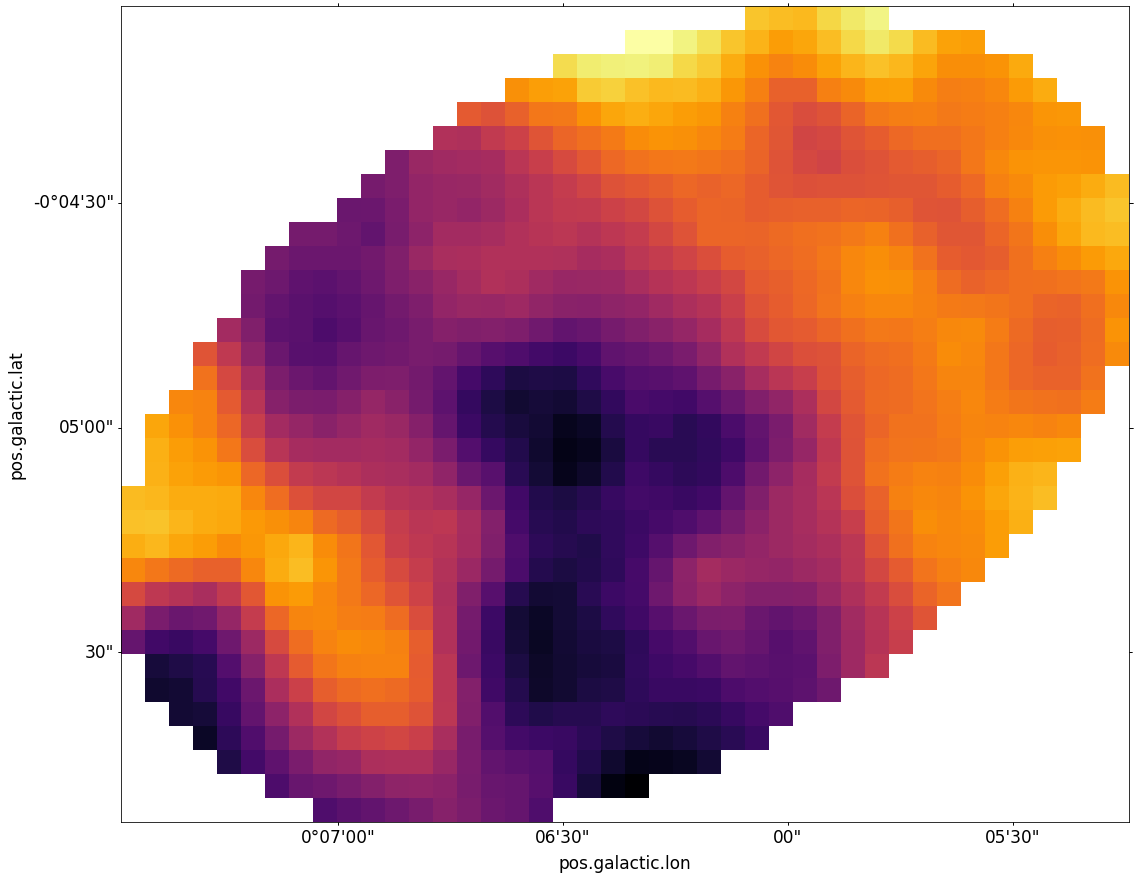

In [61]:
filename='output_masked_Br2.fits'
fig = plt.figure(figsize=(20, 15))

# Open and unpack FITS file (hdu and wcs)
file = open_files(filename)
hdu, wcs = file

# Set up the plot using WCS
coord = plt.subplot(111, projection=wcs, slices=('x', 'y'))
lon = coord.coords[0]
lat = coord.coords[1]

# Plot the FITS image
coord.imshow(hdu.data, origin='lower', norm=LogNorm(), cmap='inferno')


# Smoothing files

In [11]:
def reproj_mask(filename, mask_filename, output_filename, threshold=1):
    """
    Takes in a FITS file and mask filenames, applies the mask to the data, and saves the masked data to a new FITS file.
    
    Parameters:
    - filename: str, the path to the input FITS file
    - mask_filename: list of str, paths to mask files (can be region files or FITS files)
    - output_filename: str, the path to save the masked output FITS file
    - threshold: float, the minimum value to consider a pixel part of the mask
    
    Returns:
    - masked_data: numpy masked array containing the masked data
    """
    # Open the input FITS file and extract the HDU (data and header) and WCS
    file = open_files(filename)
    hdu, wcs = file
    header = hdu.header  # Extract the header to preserve WCS information

    # Initialize mask_filled to combine all masks
    mask_filled = np.zeros(hdu.data.shape, dtype=bool)

    # Handle case with multiple mask files
    for i in range(len(mask_filename)):
        if mask_filename[i].endswith('.reg'):  # If it's a region file
            regions = Regions.read(mask_filename[i])  # Load the region file
            for region in regions:
                # Convert the region to pixel coordinates
                pixel_region = region.to_pixel(wcs)

                # Combine the region mask with the filled mask
                mask_filled |= pixel_region.to_mask(mode='center').to_image(hdu.data.shape).astype(bool)
        else:
            mask_file = open_files(mask_filename[i])  # Access each FITS mask file by index
            hdu_mask, wcs_mask = mask_file

            # Reproject the mask and combine with existing mask
            result_reproj, _ = reproject_interp((hdu_mask.data, wcs_mask), wcs, shape_out=hdu.data.shape)
            
            # Apply threshold to the reprojected mask
            mask_outline = np.where(result_reproj == threshold, True, False)  # Threshold for mask
            
            # Fill holes in the mask and combine with existing mask
            mask_filled |= ndimage.binary_fill_holes(mask_outline)

    # Apply the final combined mask to the data
    masked_data = np.ma.masked_array(hdu.data, mask=mask_filled)

    # Save masked data to new FITS file with the original header and WCS
    masked_data_filled = np.ma.filled(masked_data, np.nan)  # Replace masked areas with NaN

    # Create a new Primary HDU to store the masked data
    hdu_new = fits.PrimaryHDU(data=masked_data_filled, header=header)

    # Write the new FITS file
    hdu_new.writeto(output_filename, overwrite=True)

    return masked_data


In [ ]:
    masked_data = reproj_mask(
    filename='destripe_l000_blue_wgls_rcal_cropped.fits',
    mask_filename=['../id_mask_mosaic_FULL_zeros.fits','Terrier_2018_all.reg','../70um_sources_to_nans_mask.fits'],
    output_filename='70um_all_masks_unsmoothed.fits'
)
    masked_data = reproj_mask(
    filename='destripe_l000_blue_wgls_rcal_cropped.fits',
    mask_filename=['../id_mask_mosaic_FULL_zeros.fits','Terrier_2018_all.reg'],
    output_filename='70um_all_masks_unsmoothed_with_sources.fits'
)


/var/folders/8n/_rhj_p6j11j3hj9wn3tzy0280000gn/T/ipykernel_7371/1648969678.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2,1,1, projection=wcs, slices=('x', 'y'))
/Users/danyaalboslani/opt/anaconda3/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:254: UserWarning: The following kwargs were not used by contour: 'color'
  cset = super().contour(*args, **kwargs)


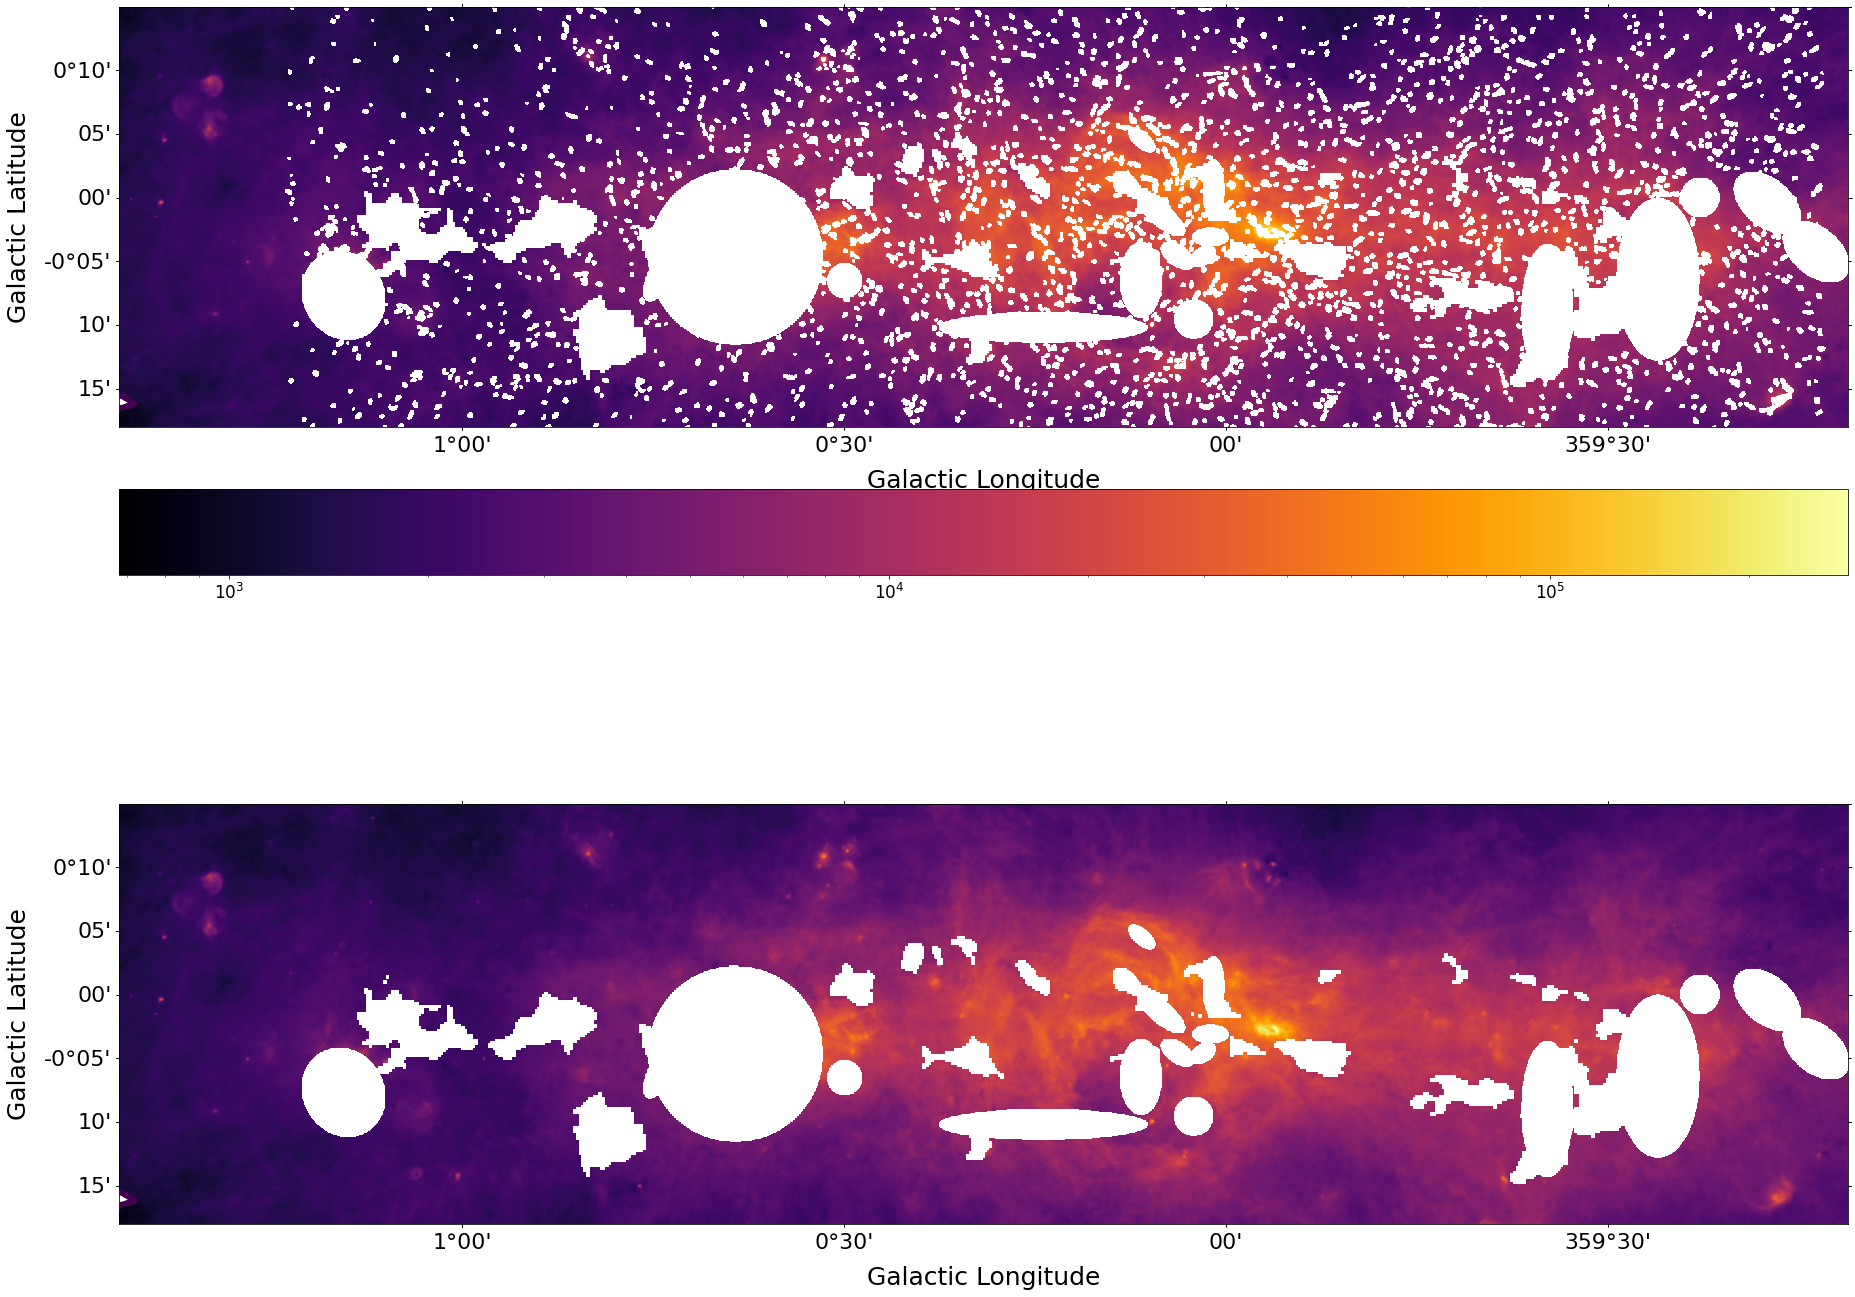

In [62]:
filename='70um_all_masks_unsmoothed.fits'

# Open and unpack FITS file (hdu and wcs)
file = open_files(filename)
hdu, wcs = file

fig, ax = plt.subplots(figsize=(31, 25))
ax = plt.subplot(2,1,1, projection=wcs, slices=('x', 'y'))
im = ax.imshow(hdu.data, origin='lower', cmap='inferno', norm=LogNorm())
lon = ax.coords[0]
lat = ax.coords[1]
ax.set_xlabel('Galactic Longitude',size=25)
lon.set_ticklabel(size=22)
ax.set_ylabel('Galactic Latitude',size=25)
lat.set_ticklabel(size=22)
pixel_min, pixel_max = plot_coords_galactic(file, (1.45, -0.3), (359.185, .25))
ax.set_xlim(pixel_min[0], pixel_max[0])
ax.set_ylim(pixel_min[1], pixel_max[1])
ax.contour(hdu.data,levels=[1],color='cyan',linewidths=5)

ax2 = plt.subplot(2,1,2, projection=wcs, slices=('x', 'y'))
im = ax2.imshow(masked_data, origin='lower', cmap='inferno', norm=LogNorm())
lon = ax2.coords[0]
lat = ax2.coords[1]
ax2.set_xlabel('Galactic Longitude',size=25)
lon.set_ticklabel(size=22)
ax2.set_ylabel('Galactic Latitude',size=25)
lat.set_ticklabel(size=22)
pixel_min, pixel_max = plot_coords_galactic(file, (1.45, -0.3), (359.185, .25))
ax2.set_xlim(pixel_min[0], pixel_max[0])
ax2.set_ylim(pixel_min[1], pixel_max[1])
ax2.contour(hdu.data,levels=[1],color='cyan',linewidths=5)
# Show the plot
plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.1)
plt.show()

In [12]:
class smoothing(Person):
    @staticmethod
    def smooth8um(filename, output_filename):
        """
        Opens background file, smooths masked_data and writes it to a FITS file.
        """
        # Load the FITS file and extract the background data
        background_file = fits.open(filename)
        background = background_file[0].data
        h_hers70 = pyfits.getheader(filename)

        # Gaussian smoothing parameters
        r_eff = 3  # arcmin
        res = r_eff / np.sqrt(2)
        test_res = res * 60  # arcmin to arcseconds
        spitz_res = 1.98 / 2.355  # FWHM to sigma (8um channel FWHM=1.98 arcseconds)

        # Calculate sigma for Gaussian kernel
        sig_gauss = np.sqrt(test_res**2 - spitz_res**2)
        kern = sig_gauss / 1.2  # arcsec/pixel
        smoothed = convolve_fft(background, Gaussian2DKernel(x_stddev=kern), normalize_kernel=True, preserve_nan=False, allow_huge=True)

        pyfits.writeto(output_filename, smoothed, h_hers70, overwrite=True) 


    @staticmethod
    def smooth70um(filename, output_filename):
        """
        Opens 70um file, smooths it, and then writes it to a FITS file.
        """
        background_file = pyfits.open(filename) 

        ## copy the FITS data into a numpy array##
        background = background_file[0].data
        h_hers70 = pyfits.getheader(filename)

        r_eff = 3 #arcmin
        res = r_eff/np.sqrt(2)
        test_res = res * 60 #arcmin * (60"/arcmin), want in arcseconds

        # sigma = FWHM/2.355
        hers70_res = 6/2.355 #70um channel FWHM=6"

        sig_gauss = np.sqrt(test_res**2 - hers70_res**2 )
        kern = sig_gauss/(3.2) #arcsec/pix
        smoothed = convolve_fft(background, Gaussian2DKernel(x_stddev=kern), normalize_kernel=True, preserve_nan=False, allow_huge=True)

        pyfits.writeto(output_filename, smoothed, h_hers70, overwrite=True) 



In [ ]:
filename='70um_all_masks_unsmoothed.fits'
crop(filename, (1.45, -0.3), (359.185, .25),output_filename='70um_all_masks_unsmoothed_cropped.fits')

smoothing.smooth70um(
    filename='70um_all_masks_unsmoothed_cropped.fits',
    output_filename='70um_smoothed_conv_36.fits'
)
masked_data_no_sources = reproj_mask(
    filename='destripe_l000_blue_wgls_rcal_cropped.fits',
    mask_filename=['../70um_sources_to_nans_mask.fits'],
    output_filename='70um_sources_removed_unsmoothed.fits'
)


In [ ]:
masked_data_8um = reproj_mask(
    filename='../GLM_00000+0000_mosaic_I4.fits',
    mask_filename=['../id_mask_mosaic_FULL_zeros.fits','Terrier_2018_all.reg','../70um_sources_to_nans_mask.fits'],
    output_filename='8um_all_masks_unsmoothed.fits'
)

In [ ]:
filename='8um_all_masks_unsmoothed.fits'
crop(filename, (1.45, -0.3), (359.185, .25),output_filename='8um_all_masks_unsmoothed_cropped.fits')

In [ ]:
smoothing.smooth8um(filename='8um_all_masks_unsmoothed_cropped.fits',
    output_filename='8um_smoothed_no_sources.fits'
)

In [89]:
filename='../data/GLM_00000+0000_resid_I4.fits'
crop(filename, (1.45, -0.3), (359.185, .25),output_filename='GLM_00000+0000_resid_I4.fits_unsmoothed_cropped.fits')

/var/folders/8n/_rhj_p6j11j3hj9wn3tzy0280000gn/T/ipykernel_20180/2686947056.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1, projection=wcs, slices=('x', 'y'))


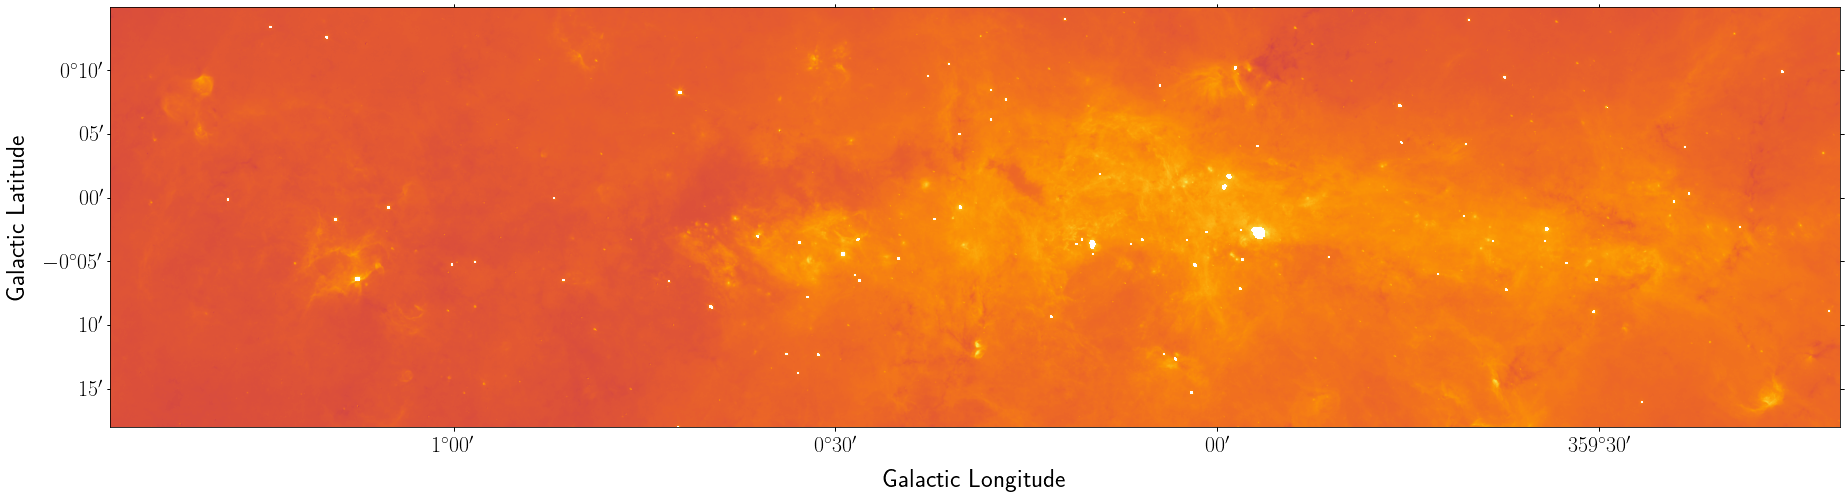

In [91]:
filename='GLM_00000+0000_resid_I4.fits_unsmoothed_cropped.fits'

# Open and unpack FITS file (hdu and wcs)
file = open_files(filename)
hdu, wcs = file

fig, ax = plt.subplots(figsize=(31, 25))
ax = plt.subplot(1,1,1, projection=wcs, slices=('x', 'y'))
im = ax.imshow(hdu.data, origin='lower', cmap='inferno', norm=LogNorm())
lon = ax.coords[0]
lat = ax.coords[1]
ax.set_xlabel('Galactic Longitude',size=25)
lon.set_ticklabel(size=22)
ax.set_ylabel('Galactic Latitude',size=25)
lat.set_ticklabel(size=22)
#pixel_min, pixel_max = plot_coords_galactic(file, (1.45, -0.3), (359.185, .25))
#ax.set_xlim(pixel_min[0], pixel_max[0])
#ax.set_ylim(pixel_min[1], pixel_max[1])
#ax.contour(hdu.data,levels=[1],color='cyan',linewidths=5)


# Creating all other files!

In [122]:
# Instantiate the class with the selected regions
individual_masks = IndividualMasks(combined_dict)

#herschel to 70um regrid
individual_masks.reproject_and_save(
    'hersch_colden_to_70um.fits',
    'hersch_to_70um_mask_regrid_{}.fits' 
)
#70um unsmoothed with sources
individual_masks.reproject_and_save(
    'destripe_l000_blue_wgls_rcal_cropped.fits',
    '70um_data_unsmoothed_mask_{}.fits'  
)
#70um smoothed
individual_masks.reproject_and_save(
    '70um_smoothed_conv_36.fits',
    '70um_data_smoothed_mask_{}.fits'  
)
#70um no sources not smoothed
individual_masks.reproject_and_save(
    '70um_sources_removed_unsmoothed.fits',
    '70um_sources_removed_unsmoothed_mask_{}.fits' 
)

#Individual masks Herschel column density
individual_masks.reproject_and_save(
    '../data/herschel_column.fits',
    'hersch_colden_masks_{}.fits'  
)


<class 'tuple'>
Saved masked FITS file: hersch_to_70um_mask_regrid_BR1.fits
<class 'tuple'>
Saved masked FITS file: hersch_to_70um_mask_regrid_BR2.fits
<class 'tuple'>
Saved masked FITS file: hersch_to_70um_mask_regrid_MC1.fits
<class 'tuple'>
Saved masked FITS file: hersch_to_70um_mask_regrid_MC2.fits
<class 'tuple'>
Saved masked FITS file: 70um_data_unsmoothed_mask_BR1.fits
<class 'tuple'>
Saved masked FITS file: 70um_data_unsmoothed_mask_BR2.fits
<class 'tuple'>
Saved masked FITS file: 70um_data_unsmoothed_mask_MC1.fits
<class 'tuple'>
Saved masked FITS file: 70um_data_unsmoothed_mask_MC2.fits
<class 'tuple'>
Saved masked FITS file: 70um_data_smoothed_mask_BR1.fits
<class 'tuple'>
Saved masked FITS file: 70um_data_smoothed_mask_BR2.fits
<class 'tuple'>
Saved masked FITS file: 70um_data_smoothed_mask_MC1.fits
<class 'tuple'>
Saved masked FITS file: 70um_data_smoothed_mask_MC2.fits
<class 'tuple'>
Saved masked FITS file: 70um_sources_removed_unsmoothed_mask_BR1.fits
<class 'tuple'>
Sa

# Calculating Extinction

In [128]:
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp

def regridding(old_filename, new_filename, output_filename):
    # Open the old FITS file
    file = open_files(old_filename)
    hdu, wcs = file

    # Open the new FITS file
    new_file = open_files(new_filename)
    new_hdu, new_wcs = new_file

    # Reproject the old data to the new WCS
    rescaled_data, _ = reproject_interp((hdu.data, wcs), new_hdu.header)

    # Create a new HDU for the rescaled data with the new header
    rescaled_imagehdu = fits.PrimaryHDU(data=rescaled_data, header=new_hdu.header)

    # Optional: Verify the WCS from the rescaled image
    rescaled_wcs = WCS(rescaled_imagehdu.header)

    # Save the rescaled HDU to a new FITS file

    rescaled_imagehdu.writeto(output_filename, overwrite=True)
    print('all done!')

regridding('../data/herschel_column.fits','destripe_l000_blue_wgls_rcal_cropped.fits','hersch_colden_to_70um.fits')

all done!


# Subplots

In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits as pyfits
from astropy.wcs import WCS
from astropy.convolution import convolve_fft, Gaussian2DKernel

class Person:
    def __init__(self, sub_dict, selected_names=None):
        self.region = []
        self.name = []
        
        if selected_names:
            for name in selected_names:
                if name in sub_dict:
                    self.region.append(sub_dict[name])
                    self.name.append(name)
        else:
            self.region = list(sub_dict.values())
            self.name = list(sub_dict.keys())

class plot_70um(Person):
    def abline(self, slope, intercept):
        """Plot a line from slope and intercept"""
        x_vals = np.arange(-1,30)
        y_vals = intercept + slope * x_vals
        return x_vals, y_vals
    def LOG_opacity(self,v, k0, k11, k13):
        nH = 10**6
        t_coag = 10**5
        
        a = (1./2) * (np.log10(k0)**2 - 4*(np.log10(k11)**2) + 3*(np.log10(k13)**2)) \
                    /(np.log10(k0) - 4*np.log10(k11) + 3*np.log10(k13))
                        
        b = (1./4) * ((np.log10(k13)-np.log10(k11))*(np.log10(k13)-np.log10(k0))*(np.log10(k11)-np.log10(k0)))\
                        /(np.log10(k0) - 4*np.log10(k11) + 3*np.log10(k13))
                        
        lgk = a - np.sqrt( (a-np.log10(k13))**2 + b*(np.log10(nH*t_coag)-13)**2  )
        
        return v, lgk

        #Feb 27th, 2023 Redid all the dumb geometry that was previously done Feb 27th, 2009...
    #GAH! Law of cosines!

    #Distribution of stars proportional to e^-(R/h_{R})
    def disk_dist(self,d, n0, l):
        R_sun = 8.4 #kpc
        h_R = 3.5 #Galactic radial scale in kpc
        R = np.sqrt(d**2 + R_sun**2 -(2*d*R_sun*np.cos(np.deg2rad(l))))    

        return n0 * np.exp(-R/h_R)##Function to automate 70um fits##

    #define extinction surface density function
    #f_fore is the fraction of LOS emission from foreground
    #I_0_obs is intensity behind cloud
    #I_1_obs is intensity in front of cloud
    def Sigma_70um(self,f_fore, I_0_obs, I_1_obs):
        k_v = 1.74 #cm^2/g #dust opacity for 70um
        return (-1./k_v) * np.log(  (I_1_obs - (f_fore*I_0_obs)) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


        #If the front of cloud intensity is much larger than the assumed background, the log() will be positive
        #And the sigma will come out negative

        #Will return nans if doing log of negative number (i.e. if the background is MUCH higher than the front of
        #the cloud)

        #Convert to col den = (Sigma/mu*m_H)
    def N(self,sig):
        mu = 2.8
        m_H = 1.67e-24 #g
        return sig/(mu*m_H)


    #70um extinction column density calculation 
    #70um extinction column density calculation 
    def cloud_extinction_calc_70um(self,hers, f_fore, smoothed, obs):
        #Create list to populate 
        Sigma = np.zeros(shape=(len(hers),len(hers[0])))
        ext_N = np.zeros(shape=(len(hers),len(hers[0])))
        
        #For-loop for 2D array, first y then x
        for i in np.arange(len(hers)):

            for j in np.arange(len(hers[0])):
                if smoothed[i][j] == np.NaN:
                    Sigma[i][j] = np.NaN
                    ext_N[i][j] = np.NaN

                else:
                    sig = self.Sigma_70um(f_fore, smoothed[i][j], obs[i][j])
                    Sigma[i][j] = sig
                    ext_N[i][j] = self.N(sig)
                    
        return ext_N

    #optical depth conversion for later plotting
    def tau_nu(self,NH2,k_v):
        mu = 2.8
        m_H = 1.67e-24 #g
        return k_v * (NH2*mu*m_H)
    def cloud_EmvsExt_NANS_and_SUB(self, cloud, f_fore=0.5):
        cloud_herschel_regrid_fits = pyfits.open("hersch_to_70um_mask_regrid_{}.fits".format(cloud))
        cloud_70um_fits = pyfits.open("70um_data_unsmoothed_mask_{}.fits".format(cloud))
        cloud_70um_smoothed_fits = pyfits.open('70um_data_smoothed_mask_{}.fits'.format(cloud))
        
        cloud_70um = cloud_70um_fits[0].data
        cloud_70um_smoothed = cloud_70um_smoothed_fits[0].data
        cloud_hers_regrid_70 = cloud_herschel_regrid_fits[0].data
        h_cloud_70um = pyfits.getheader("hersch_to_70um_mask_regrid_{}.fits".format(cloud))

        cloud_ext_N_nans = self.cloud_extinction_calc_70um(cloud_hers_regrid_70,f_fore, cloud_70um_smoothed, cloud_70um)
        # Update this line with proper formatting
        pyfits.writeto('70umExtN_ffore{:.2f}_tonans_{}.fits'.format(f_fore, cloud), cloud_ext_N_nans, h_cloud_70um, overwrite=True)

        return
    def convolve(self, f_fore=0.5):
        higal_colden_res = 36 / 2.355  # sigma = FWHM/sqrt(8ln2)
        highal70_res = 6 / 2.355
        sig_gauss = np.sqrt(higal_colden_res**2 - highal70_res**2)
        kern = sig_gauss / 3.2  # arcsec/pix

        for cloud in self.name:
            self.cloud_EmvsExt_NANS_and_SUB(cloud, f_fore)

            nans_sub_file = '70umExtN_ffore{:.2f}_tonans_{}.fits'.format(f_fore, cloud)
            nans_sub_data = pyfits.open(nans_sub_file)[0].data

            hers70um = 'destripe_l000_blue_wgls_rcal_cropped.fits'
            h_nans = pyfits.getheader(nans_sub_file)
            h_hers70 = pyfits.getheader(hers70um)

            smoothed_nans = convolve_fft(nans_sub_data, Gaussian2DKernel(x_stddev=kern), normalize_kernel=True, preserve_nan=True, allow_huge=True)

            pyfits.writeto('ExtN70um_sources_to_nans_ffore{:.2f}_cutout_smoothed_conv36_{}.fits'.format(f_fore, cloud), 
                           smoothed_nans, h_nans, overwrite=True)

            # Regridding
            conv_file = pyfits.open('ExtN70um_sources_to_nans_ffore{:.2f}_cutout_smoothed_conv36_{}.fits'.format(f_fore, cloud))[0]
            cloud_hers_cutout = pyfits.open('hersch_colden_masks_{}.fits'.format(cloud))[0]
            regrid_array, regrid_footprint = reproject_interp(conv_file, cloud_hers_cutout.header)

            pyfits.writeto('ExtN70um_sources_to_nans_ffore{:.2f}_cutout_smoothed_conv36_regrid_isolated_{}.fits'.format(f_fore, cloud), 
                            regrid_array, cloud_hers_cutout.header, overwrite=True)

    def plot_extinction(self, f_fore=0.5):
        ext_list_70_conv = []
        em_list_70_conv = []

        num_clouds = len(self.name)
        num_columns = 4  # Set number of columns to 3
        num_rows = (num_clouds + num_columns - 1) // num_columns  # Calculate the number of rows needed

        # Create a grid of subplots with 3 columns
        fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(25, 5 * num_rows))

        # Flatten the axes array to make indexing easier when plotting
        axes = axes.flatten()

        for idx, cloud in enumerate(self.name):
            regrid_to_nans_file = 'ExtN70um_sources_to_nans_ffore{:.2f}_cutout_smoothed_conv36_regrid_isolated_{}.fits'.format(f_fore, cloud)
            regrid_to_nans_data = pyfits.open(regrid_to_nans_file)[0].data

            cloud_hers = 'hersch_colden_masks_{}.fits'.format(cloud)
            cloud_hers_data = pyfits.open(cloud_hers)[0].data

            em_list_70_conv.append(np.nanmedian(cloud_hers_data) / 10**22)
            ext_list_70_conv.append(np.nanmedian(regrid_to_nans_data) / 10**22)

            # Create the WCS object
            wcs = WCS(pyfits.open(regrid_to_nans_file)[0].header)

            ax = axes[idx]  # Select the correct subplot axis

             # Initialize a flag to run correlation calculation only once
            correlation_done = False
            # Generate the abline
            x = np.arange(-1,30)
            y = np.arange(-1,30)
            x_vals, y_vals = self.abline(0, 3.5) 

            y_vals = np.arange(-5,30)
            x_vals = np.full(np.shape(y_vals),16)

            # Scatter plot of the data
            ax.scatter(cloud_hers_data / 1E22, regrid_to_nans_data / 1E22, marker='+', color='k', alpha=0.5)

            # Plot the abline
            ax.plot(x, y, c='black')

            ax.hlines(0, -1, 30, linestyle='--', color='gray')
            ax.set_ylim(-30, 30)
            ax.set_xlim(0, 32)

            # Add x and y labels only on leftmost and bottommost subplots
            if idx % num_columns == 0:  # Leftmost column, show y-axis
                ax.set_ylabel(r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from Herschel 70 $\mu$m regridded")
            else:  # Hide y-axis on other columns
                ax.set_yticklabels([])

            if idx >= num_columns * (num_rows - 1):  # Bottommost row, show x-axis
                ax.set_xlabel(r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from Hi-GAL")
            else:  # Hide x-axis on other rows
                ax.set_xticklabels([])

            if not correlation_done:
                xy_thin = pd.DataFrame({'Herschel thin': cloud_hers_data.flatten(), 'Ext Col Den thin': regrid_to_nans_data.flatten()})
                optically_thin_corr = xy_thin['Herschel thin'].corr(xy_thin['Ext Col Den thin'])

                xy_all = pd.DataFrame({'Herschel': cloud_hers_data.flatten(), 'Ext Col Den': regrid_to_nans_data.flatten()})
                all_points_corr = xy_all['Herschel'].corr(xy_all['Ext Col Den'])

                # Set the flag to True so it doesn't run again
                correlation_done = True
            # Add cloud name in the top-right of each subplot
            ax.text(.70, .99, '{}'.format(cloud), ha='left', va='top', transform=ax.transAxes,fontsize=20)

            # Correlations
            ax.text(.12, .95, r'\textbf{\underline{Correlations}}', transform=ax.transAxes, ha='center', fontsize=15)
            ax.text(.245, .90, f'Optically Thin Points: {optically_thin_corr:.3f}', transform=ax.transAxes, ha='center', fontsize=15)
            ax.text(.155, .85, f'All Points: {all_points_corr:.3f}', transform=ax.transAxes, ha='center', fontsize=15)

        # Hide any unused subplots
        for ax in axes[num_clouds:]:
            ax.axis('off')

        # Adjust layout to prevent overlapping
        plt.tight_layout()
        plt.show()

    def run_all(self, f_fore=0.5):
        # Call each method in the order you want them to execute
        self.convolve(f_fore)
        self.plot_extinction(f_fore)

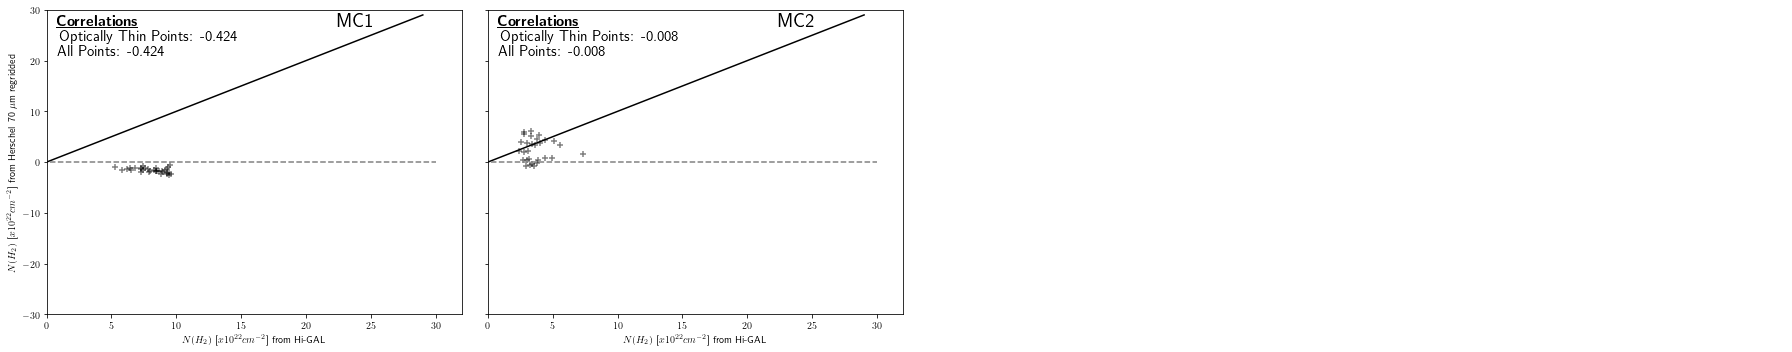

In [171]:
#selected_region_names = ['MC1','MC2','Br1', 'Br2']
#selected_region_names=list(contours.keys()) #for thse entire list of clouds in contours
# Create a filtered dictionary for the selected regions
contours=combined_dict
# Assuming 'index' is a tuple, and we want the array part (index[0])
cloud_dict = {name: index[0] for name, index in contours.items()}

# Now filter based on selected_region_names
selected_region_names = ['MC1', 'MC2', 'Br1', 'Br2']
sub_dict = {name: cloud_dict[name] for name in selected_region_names if name in cloud_dict}
plot_extinction_instance = plot_70um(sub_dict)
# Call the plotting method separately (assuming it's named `plot_extinction`) 
plot_extinction_instance.run_all()
#plot_extinction_instance.plot_extinction(f_fore=0.5) 

# Other plots

In [ ]:
class other_plots(Person):
    def plot_six_panel_cloud(self, Cloud, sub_dict):
            # Assuming sub_dict contains relevant data for plotting
            
            # Load your FITS files as before
            example_smoothed = pyfits.open('70um_data_smoothed_mask_{}.fits'.format(Cloud))[0].data
            wcs_smoothed = WCS(pyfits.open('70um_data_smoothed_mask_{}.fits'.format(Cloud))[0].header)

            example_70um = pyfits.open("70um_data_unsmoothed_mask_{}.fits".format(Cloud))[0].data
            wcs_70um = WCS(pyfits.open("70um_data_unsmoothed_mask_{}.fits".format(Cloud))[0].header)

            example_70um_masked = pyfits.open("70um_no_sources_unsmoothed_mask_{}.fits".format(Cloud))[0].data
            example_70um_ExtN = pyfits.open('70umExtN_ffore0.50_tonans_{}.fits'.format(Cloud))[0].data
            example_70um_ExtN_conv_regrid = pyfits.open('ExtN70um_sources_to_nans_ffore0.50_cutout_smoothed_conv36_regrid_isolated_{}.fits'.format(Cloud))[0].data

            example_hershel = pyfits.open('hersch_colden_masks_{}.fits.fits'.format(Cloud))[0].data
            wcs_herschel = WCS(pyfits.open('hersch_colden_masks_{}.fits.fits'.format(Cloud))[0].header)

            # Proceed with plotting as before
            plt.rcParams.update({'font.size': 10})
            fig, ax = plt.subplots(2, 3, subplot_kw={'projection': wcs_70um}, figsize=(10, 8), dpi=300)

            # Match color scales and plot data
            im_70um = ax[0, 0].imshow(example_70um, cmap='bone')
            vmin_70um, vmax_70um = im_70um.get_clim()
            
            im_70um_masked = ax[0, 1].imshow(example_70um_masked, vmin=vmin_70um, vmax=vmax_70um, cmap='bone')
            im_70um_smoothed = ax[0, 2].imshow(example_smoothed, vmin=vmin_70um, vmax=vmax_70um, cmap='bone')

            # Continue with the rest of the plotting code...
            
            # Example usage of sub_dict: you could plot specific regions or modify titles based on sub_dict data
            for key, value in sub_dict.items():
                ax[0, 0].text(0.5, 0.5, f'{key}: {value}', transform=ax[0, 0].transAxes, fontsize=8, ha='center')

            plt.tight_layout(w_pad=0.5, h_pad=6)
            
            # Create colorbars and finalize the plot
            cb1 = fig.colorbar(im_70um, ax=ax[0, 0], location='top', pad=0.0)
            cb1.set_label(label=r'[MJy/sr]', labelpad=-14, x=0.96, rotation=0, fontsize=7)
            
            # Show the plot
            plt.show()


peak N(H2) = 1.5948683829519983e+23


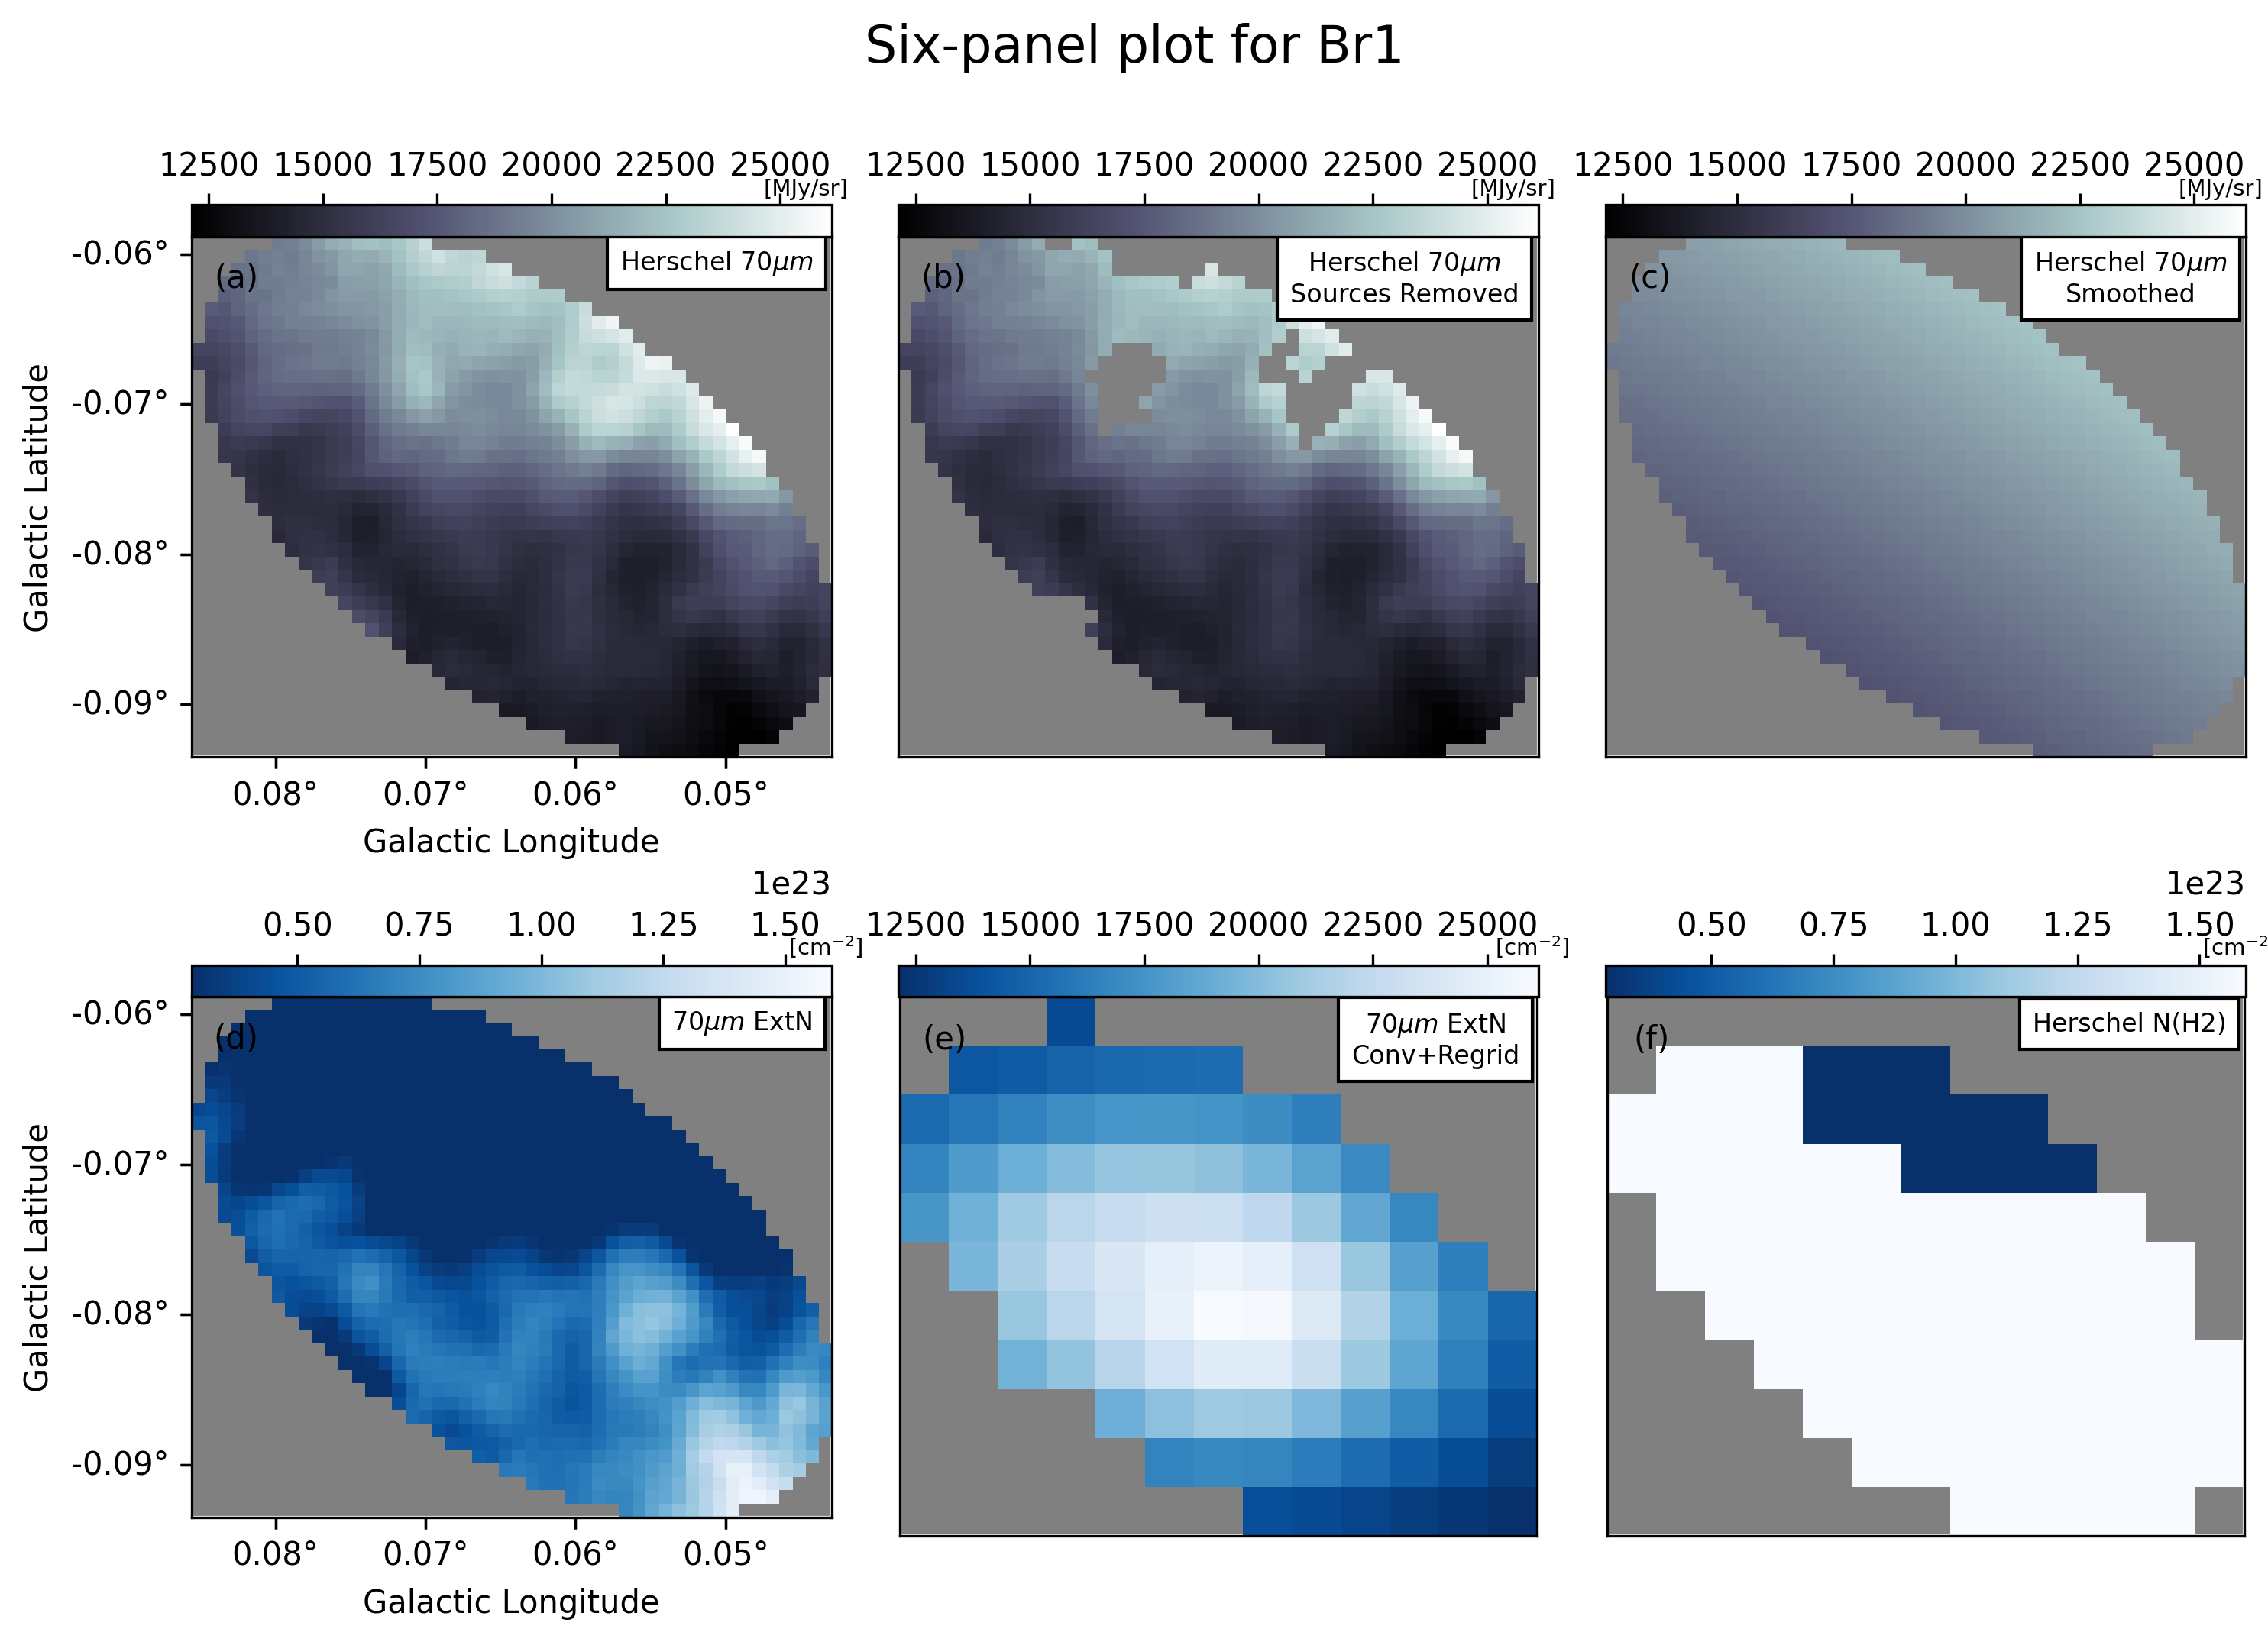

peak N(H2) = 1.3986512309310783e+23


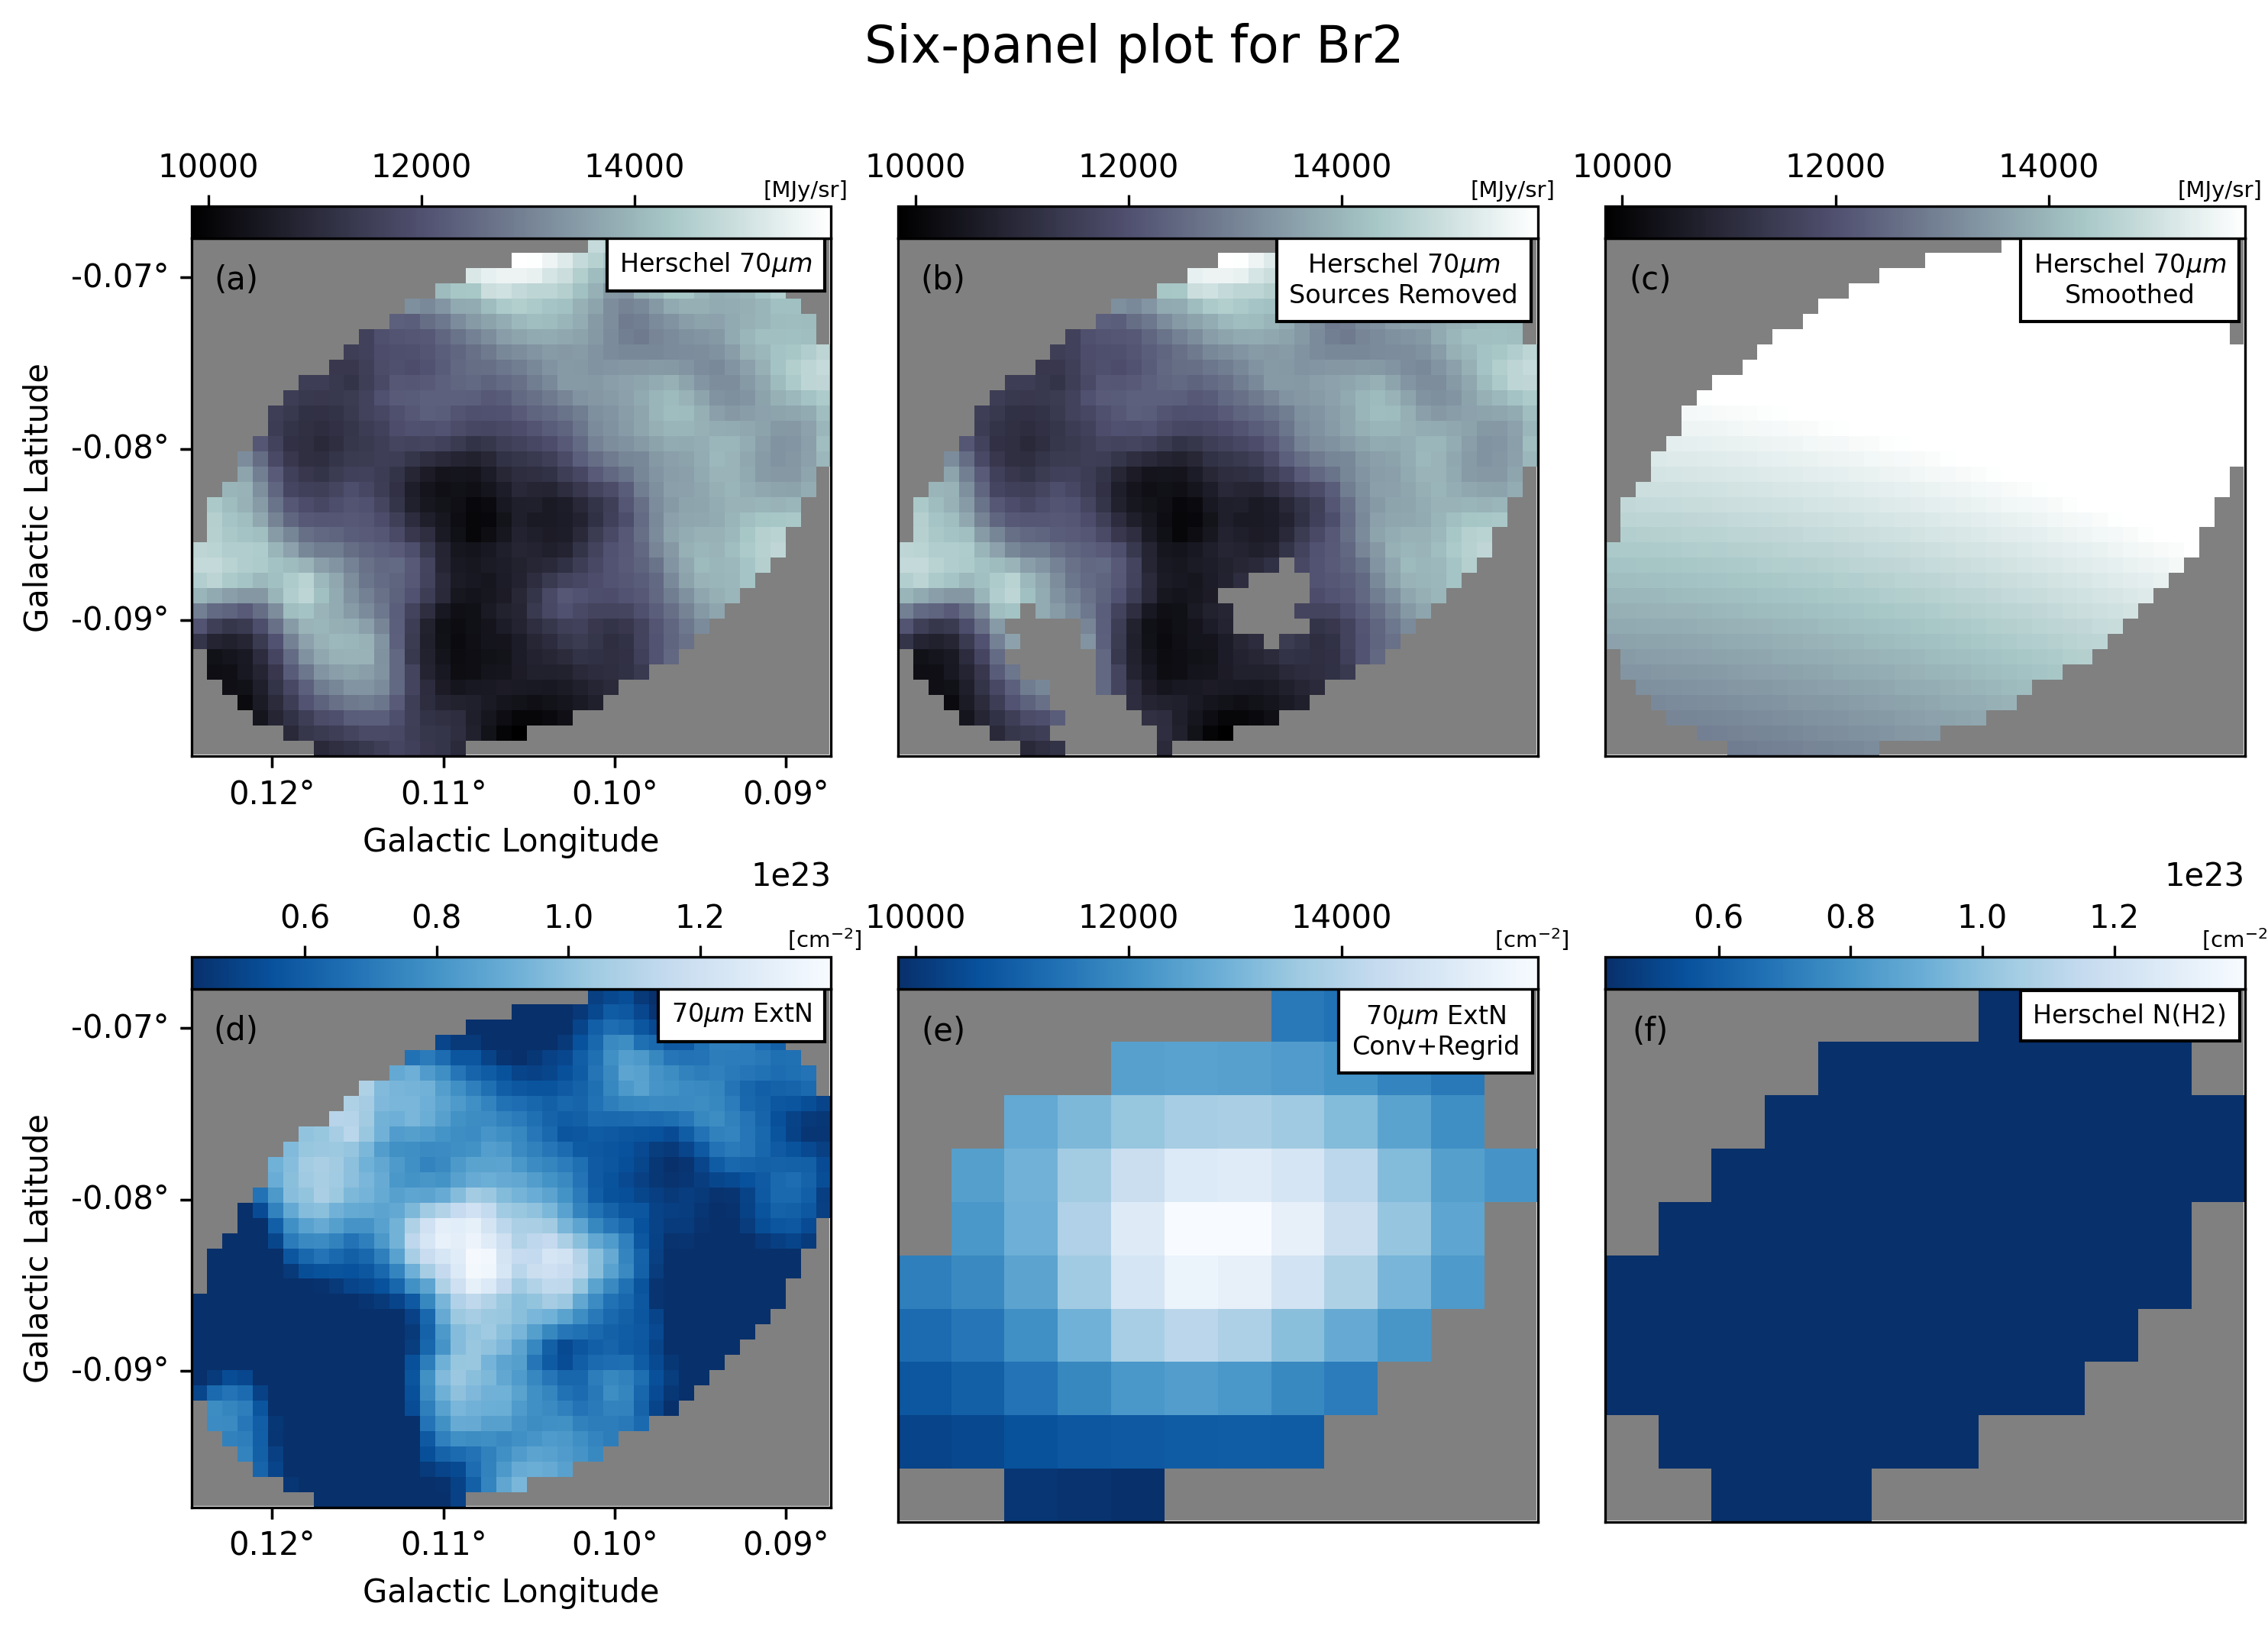

In [67]:
class other_plots(Person):
    def plot_six_panel_cloud(self, sub_dict):
        # Get the cloud name from the keys of sub_dict
        #Cloud = list(sub_dict.keys())[0]  # Assuming sub_dict has at least one key
        for Cloud in sub_dict.keys():
                # Load your FITS files as before
                example_smoothed = pyfits.open('70um_data_smoothed_mask_{}.fits'.format(Cloud))[0].data
                wcs_smoothed = WCS(pyfits.open('70um_data_smoothed_mask_{}.fits'.format(Cloud))[0].header)

                example_70um = pyfits.open("70um_data_unsmoothed_mask_{}.fits".format(Cloud))[0].data
                wcs_70um = WCS(pyfits.open("70um_data_unsmoothed_mask_{}.fits".format(Cloud))[0].header)

                example_70um_masked = pyfits.open("70um_sources_removed_unsmoothed_mask_{}.fits".format(Cloud))[0].data
                example_70um_ExtN = pyfits.open('70umExtN_ffore0.50_tonans_{}.fits'.format(Cloud))[0].data
                example_70um_ExtN_conv_regrid = pyfits.open('ExtN70um_sources_to_nans_ffore0.50_cutout_smoothed_conv36_regrid_isolated_{}.fits'.format(Cloud))[0].data

                example_hershel = pyfits.open('hersch_colden_masks_{}.fits'.format(Cloud))[0].data
                wcs_herschel = WCS(pyfits.open('hersch_colden_masks_{}.fits'.format(Cloud))[0].header)

                # Proceed with plotting as before
                plt.rcParams.update({'font.size': 10})
                fig, ax = plt.subplots(2, 3, subplot_kw={'projection': wcs_70um}, figsize = (10,8), dpi = 300)
                #ax_5 = fig.add_subplot(2,3,5, projection=wcs_herschel)
                #ax_6 = fig.add_subplot(2,3,6, projection=wcs_herschel, sharex=ax_5, sharey=ax_5)

                
                mpl.rc('image', cmap='Blues_r')


                #match 70um and 70um masked colorscales 
                im_70um = ax[0,0].imshow(example_70um, cmap='bone')
                vmin_70um, vmax_70um = im_70um.get_clim()
                
                im_70um_masked = ax[0,1].imshow(example_70um_masked, vmin=vmin_70um, vmax=vmax_70um, cmap='bone')
                
                
                im_70um_smoothed = ax[0,2].imshow(example_smoothed, vmin=vmin_70um, vmax=vmax_70um, cmap='bone')
                
                

                #match 70um Ext and 70um Ext Conv/Regrid colorscales 
                #im_herschel = ax_6.imshow(example_hershel)
                
                
                im_herschel = ax[1,1].imshow(example_hershel)
                im_70um_ExtN_conv_regrid = ax[1,2].imshow(example_70um_ExtN_conv_regrid, vmin=vmin_70um, vmax=vmax_70um)
                vmin_hers, vmax_hers = im_herschel.get_clim()
                
                im_70um_ExtN = ax[1,0].imshow(example_70um_ExtN, vmin=vmin_hers, vmax=vmax_hers)
                #im_70um_ExtN_conv_regrid = ax_5.imshow(example_70um_ExtN_conv_regrid, vmin=vmin_hers, vmax=vmax_hers)
                vmin_70Ext, vmax_70Ext = im_70um_ExtN.get_clim()

                print("peak N(H2) = {}".format(np.nanmax(example_hershel)) )
        
    
                ###BEAUTIFY PLOTS####    

                for i in range(2):
                        for j in range(3):
                                lon = ax[i,j].coords['glon']
                                lat = ax[i,j].coords['glat']
                                lon.set_ticks_visible(False)
                                lon.set_ticklabel_visible(False)
                                lat.set_ticks_visible(False)
                                lat.set_ticklabel_visible(False)
                                lon.set_axislabel('')
                                lat.set_axislabel('')
                                ax[i,j].set_facecolor('grey')
                        
                        
                #ax[0,0] and ax[1,0] can keep labels and ticks, the rest dont need them

                lon = ax[0,0].coords['glon']
                lat = ax[0,0].coords['glat']
                lon.set_major_formatter('d.dd')
                lat.set_major_formatter('d.dd')
                lon.set_ticks_visible(True)
                lon.set_ticklabel_visible(True)
                lat.set_ticks_visible(True)
                lat.set_ticklabel_visible(True)
                lon.set_ticks_position('b')
                lon.set_ticklabel_position('b')
                lon.set_axislabel_position('b')
                lat.set_ticks_position('l')
                lat.set_ticklabel_position('l')
                lat.set_axislabel_position('l')
                
                ax[0,0].set_facecolor('gray')
                ax[0,0].set_xlabel('Galactic Longitude')
                ax[0,0].set_ylabel('Galactic Latitude')
                ax[0,0].set_facecolor('grey')


                lon = ax[1,0].coords['glon']
                lat = ax[1,0].coords['glat']
                lon.set_major_formatter('d.dd')
                lat.set_major_formatter('d.dd')
                lon.set_ticks_visible(True)
                lon.set_ticklabel_visible(True)
                lat.set_ticks_visible(True)
                lat.set_ticklabel_visible(True)
                lon.set_ticks_position('b')
                lon.set_ticklabel_position('b')
                lon.set_axislabel_position('b')
                lat.set_ticks_position('l')
                lat.set_ticklabel_position('l')
                lat.set_axislabel_position('l')
                
                ax[1,0].set_facecolor('gray')
                ax[1,0].set_xlabel('Galactic Longitude')
                ax[1,0].set_ylabel('Galactic Latitude')
                ax[1,0].set_facecolor('grey')

        
        
                lon = ax[1,1].coords['glon']
                lat = ax[1,1].coords['glat']
                lon.set_ticks_visible(False)
                lon.set_ticklabel_visible(False)
                lat.set_ticks_visible(False)
                lat.set_ticklabel_visible(False)
                lon.set_axislabel('')
                lat.set_axislabel('')
                ax[1,1].set_facecolor('grey')

                lon = ax[1,2].coords['glon']
                lat = ax[1,2].coords['glat']
                lon.set_ticks_visible(False)
                lon.set_ticklabel_visible(False)
                lat.set_ticks_visible(False)
                lat.set_ticklabel_visible(False)
                lon.set_axislabel('')
                lat.set_axislabel('')
                ax[1,2].set_facecolor('grey')
                
                plt.tight_layout(w_pad = 0.5, h_pad=6)
        
        
        
                cb1 = fig.colorbar(im_70um, ax=ax[0,0], location='top',pad=0.0)
                cb2 = fig.colorbar(im_70um_masked, ax=ax[0,1], location='top',pad=0.0)
                cb3 = fig.colorbar(im_70um_smoothed, ax=ax[0,2], location='top',pad=0.0)
                cb4 = fig.colorbar(im_70um_ExtN, ax=ax[1,0], location='top',pad=0.0)
                cb5 = fig.colorbar(im_70um_ExtN_conv_regrid, ax=ax[1,1], location='top',pad=0.0)
                cb6 = fig.colorbar(im_herschel, ax=ax[1,2], location='top',pad=0.0)

                
                cb1.set_label(label = r'[MJy/sr]', labelpad=-14, x=0.96, rotation=0, fontsize = 7)
                cb2.set_label(label = r'[MJy/sr]', labelpad=-14, x=0.96, rotation=0, fontsize = 7)
                cb3.set_label(label = r'[MJy/sr]', labelpad=-14, x=0.96, rotation=0, fontsize = 7)
                
                cb4.set_label(label = r'[cm$^{-2}$]', labelpad=-14, x=0.99, rotation=0, fontsize = 7)
                cb5.set_label(label = r'[cm$^{-2}$]', labelpad=-14, x=0.99, rotation=0, fontsize = 7)
                cb6.set_label(label = r'[cm$^{-2}$]', labelpad=-14, x=0.99, rotation=0, fontsize = 7)

                
                from string import ascii_lowercase as alc

                for m in range(len(fig.axes[6:])):
                        fig.axes[m].text(0.07, 0.92,'({})'.format(alc[m]), ha='center', va='center', transform=fig.axes[m].transAxes)
                
                
                
                ax[0,0].text(0.82, 0.95,r'Herschel 70$\mu m$', ha='center', va='center', transform=ax[0,0].transAxes,
                        bbox=dict(facecolor='white', edgecolor='k', alpha=1), fontsize = 8)  
                
                ax[0,1].text(0.79, 0.92,'Herschel 70$\mu m$\nSources Removed', ha='center', va='center', transform=ax[0,1].transAxes,
                        bbox=dict(facecolor='white', edgecolor='k', alpha=1), fontsize = 8)
                ax[0,2].text(0.82, 0.92,'Herschel 70$\mu m$\nSmoothed', ha='center', va='center', transform=ax[0,2].transAxes,
                        bbox=dict(facecolor='white', edgecolor='k', alpha=1), fontsize = 8)
                ax[1,0].text(0.86, 0.95,r'70$\mu m$ ExtN', ha='center', va='center', transform=ax[1,0].transAxes,
                        bbox=dict(facecolor='white', edgecolor='k', alpha=1), fontsize = 8)
                ax[1,1].text(0.84, 0.92,"70$\mu m$ ExtN\nConv+Regrid", ha='center', va='center', transform=ax[1,1].transAxes,
                        bbox=dict(facecolor='white', edgecolor='k', alpha=1), fontsize = 8)
                ax[1,2].text(0.82, 0.95,r'Herschel N(H2)', ha='center', va='center', transform=ax[1,2].transAxes,
                        bbox=dict(facecolor='white', edgecolor='k', alpha=1), fontsize = 8)

                plt.suptitle(f'Six-panel plot for {Cloud}', fontsize=16, y=0.90)
                plt.tight_layout(rect=[0, 0, 1, 0.90])
                # Show the plot
                plt.show()

# Example usage
regions = Regions.read('Terrier_2018_all.reg', format='ds9')
# Dictionary of contour names and their region indices
contours = {
    'MC1': 0, 'MC2': 1, 'Br1': 2, 'Br2': 3, 'G0.11-0.11': 4, 'Arches': 5, 'DX': 6,
    'Fil. 2011': 7, 'G0.04-0.16': 8, 'G0.02+0.01': 9, 'G0.09-0.02': 10, 'G0.24-0.17': 11,
    'Sgr B': 12, 'Sgr B2': 13, 'G0.74-0.11': 14, 'G0.66-0.13': 15, 'G0.50-0.11': 16,
    'G0.56-0.11': 17, 'Sgr C': 18, 'C1': 19, 'C2': 20, 'C3': 21, 'C4': 22, 'M359.38-0.00': 23,
    'M359.23-0.04a': 24, 'M359.23-0.04b': 25, 'Sgr D core': 26
}
# Create a dictionary of contour names and their corresponding regions
cloud_dict = {name: regions[index] for name, index in contours.items()}

# Specify the names of the regions you want to use
selected_region_names = ['Br1', 'Br2']

# Create a filtered dictionary for the selected regions
sub_dict = {name: cloud_dict[name] for name in selected_region_names if name in cloud_dict}

other_plot_instance = other_plots(sub_dict)

# Call the method 
other_plot_instance.plot_six_panel_cloud(sub_dict)


# 8um Methods

In [141]:
class methods_8um(Person):
    def __init__(self, sub_dict, selected_names):
        super().__init__(sub_dict,selected_names)  # Initialize from parent class
        self.mean_ratio_scaled = []
        self.galactic_longitude = []
        self.ranges = []
        self.mean_diff_scaled =[]
        self.mean_ratio_scaled = []
    def create_flux_maps(self, unsmoothed_filename, smoothed_filename, threshold_diff=72.77, threshold_ratio=52.09):
        file = open_files(unsmoothed_filename)
        smoothed_file = open_files(smoothed_filename)

        hdu_smoothed, wcs_smoothed = smoothed_file
        hdu, wcs = file
        flux_diff_map = (hdu_smoothed.data - hdu.data) - threshold_diff
        flux_ratio_map = (hdu.data - threshold_ratio) / hdu_smoothed.data

        # Initialize masked arrays
        flux_diff_masked = np.empty_like(flux_diff_map)
        flux_ratio_masked = np.empty_like(flux_ratio_map)
        flux_diff_masked.fill(np.nan)
        flux_ratio_masked.fill(np.nan)

        # Stack of Flux Difference and Flux Ratio full maps contours
        fig, ax = plt.subplots(nrows=2, subplot_kw={'projection': wcs}, figsize=(35, 20), sharex=True, sharey=True)
        plt.subplots_adjust(wspace=0.0, hspace=0.0)

        # Flux Difference
        divnorm = mc.TwoSlopeNorm(vmin=-150, vcenter=-52.09, vmax=150)

        # Create mask for flux difference using sub_dict
        #masks = np.array([region.to_pixel(wcs).to_mask(mode='center').to_image(flux_diff_map.shape) for region in self.sub_dict.values()])
        #mask = np.any(masks, axis=0).astype(bool)  # Combine masks using logical OR
        mask = np.zeros(flux_diff_map.shape, dtype=bool)
        for region in self.region:
            pixel_region = region.to_pixel(wcs)
            if pixel_region.to_mask(mode='center').to_image(flux_diff_map.shape) is not None:
                mask |= pixel_region.to_mask(mode='center').to_image(flux_diff_map.shape).astype(bool)
        #diff_result=np.where(mask==1, flux_diff_map, np.nan)

        diff_result = np.ma.masked_array(flux_diff_map, ~mask)
        flux_diff_show = ax[0].imshow(diff_result, origin='lower', cmap='bwr_r', norm=divnorm)

        ax[0].set_ylabel('Galactic Latitude', fontsize=40)
        ax[0].set_facecolor('white')
        ax[0].set_xlabel(' ')
        ax[0].tick_params(axis='x', bottom=False, labelbottom=False)
        ax[0].tick_params(axis='y', left=False, labelleft=False)
        ax[0].text(0.11, 0.90, r' Flux Difference ', ha='center', va='center', transform=ax[0].transAxes,
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='k', alpha=1), fontsize=40)

        # Flux Ratio
        divnorm = mc.TwoSlopeNorm(vmin=0, vcenter=0.699, vmax=1)
        wcs = WCS(hdu.header)

        # Create mask for flux ratio using sub_dict
        #masks = np.array([region.to_pixel(wcs).to_mask(mode='center').to_image(flux_ratio_map.shape) for region in self.sub_dict.values()])
        #mask = np.any(masks, axis=0).astype(bool)  # Combine masks using logical OR
        # #diff_result = np.ma.masked_array(flux_diff_map, ~mask)
        ratio_result=np.where(mask==1, flux_diff_map, np.nan)
        ratio_result = np.ma.masked_array(flux_ratio_map, ~mask)
        flux_ratio_show = ax[1].imshow(ratio_result, origin='lower', cmap='bwr', norm=divnorm)

        ax[1].text(0.09, 0.90, r' Flux Ratio ', ha='center', va='center', transform=ax[1].transAxes,
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='k', alpha=1), fontsize=40)

        # Coordinate formatting
        lon = ax[1].coords[0]
        lat = ax[1].coords[1]
        lon.set_major_formatter('d.dd')
        lat.set_major_formatter('d.dd')

        ax[1].set_ylabel('Galactic Latitude', fontsize=40)
        ax[1].set_xlabel('Galactic Longitude', fontsize=40)
        ax[1].tick_params(axis='x', labelsize=30)
        ax[1].tick_params(axis='y', labelsize=30)
        ax[1].set_facecolor('white')

        # Colorbars
        divider1 = make_axes_locatable(ax[0])
        divider2 = make_axes_locatable(ax[1])
        cax1 = divider1.append_axes("right", size="3%", pad=0.0, axes_class=maxes.Axes)
        cax2 = divider2.append_axes("right", size="3%", pad=0.0, axes_class=maxes.Axes)

        cb1 = fig.colorbar(flux_diff_show, orientation="vertical", cax=cax1, ticks=[-100, -52., 100])
        cb1.set_label(label=r'[MJy/sr]', labelpad=-45, y=1.0, rotation=0, fontsize=30)
        cb1.ax.tick_params(labelsize=30)
        cb1.ax.text(0.3, -35, r'more likely near', color='white', rotation=-90, fontsize=30, weight='bold',
                    path_effects=[pe.withStroke(linewidth=2, foreground="black")])
        cb1.ax.text(0.3, -140, r'more likely far', color='white', rotation=-90, fontsize=30, weight='bold',
                    path_effects=[pe.withStroke(linewidth=2, foreground="black")])

        cb2 = fig.colorbar(flux_ratio_show, orientation="vertical", cax=cax2, ticks=[0, 0.7, 1.0])
        
        cb2.ax.tick_params(labelsize=30)
        cb2.ax.text(0.3, 0.64, r'more likely near', color='white', rotation=-90, fontsize=30, weight='bold',
                    path_effects=[pe.withStroke(linewidth=2, foreground="black")])
        cb2.ax.text(0.3, 0.97, r'more likely far', color='white', rotation=-90, fontsize=30, weight='bold',
                    path_effects=[pe.withStroke(linewidth=2, foreground="black")])
        cb2.ax.invert_yaxis()

        lon.set_major_formatter('d.dd')
        lat.set_major_formatter('d.dd')
        lon.set_ticks_position('b')
        lon.set_ticklabel_position('b')
        lon.set_axislabel_position('b')
        lat.set_ticks_position('l')
        lat.set_ticklabel_position('l')
        lat.set_axislabel_position('l')

        plt.show()
    
    def flux_calculations(self, unsmoothed_filename, smoothed_filename, threshold_diff=72.77, threshold_ratio=52.09):
        # Load data from FITS files
        file = open_files(unsmoothed_filename)
        smoothed_file = open_files(smoothed_filename)

        hdu_smoothed, wcs_smoothed = smoothed_file
        hdu, wcs = file
        flux_diff_map = (hdu_smoothed.data - hdu.data) - threshold_diff
        flux_ratio_map = (hdu.data - threshold_ratio) / hdu_smoothed.data

        # Scaling parameters
        flux_diff_min = 0.0
        flux_diff_max = 126.73 
        flux_ratio_min = 0.00
        flux_ratio_max = 1

        fdiff_cn = 2. * ((-52 - flux_diff_min) / (flux_diff_max - flux_diff_min)) - 1.
        fratio_cn = 2. * ((0.699 - flux_ratio_min) / (flux_ratio_max - flux_ratio_min)) - 1.

        # Create mask for the flux maps using regions from sub_dict
        for region in self.region:  # Change here
            pixel_region = region.to_pixel(wcs)
            region_mask = pixel_region.to_mask(mode='center').to_image(hdu.data.shape).astype(bool)

            # Apply mask to flux maps for the current region
            #masked_diff = np.ma.masked_array(flux_diff_map, mask=~region_mask)
            #masked_ratio = np.ma.masked_array(flux_ratio_map, mask=~region_mask)
            masked_diff = np.where(region_mask==1, flux_diff_map, np.nan)
            masked_ratio = np.where(region_mask==1, flux_ratio_map, np.nan)
            # Calculate mean values for the specific region
            mean_diff = np.nanmean(masked_diff)
            mean_ratio = np.nanmean(masked_ratio)

            # Scaling calculations
            z_fdiff_i = 2 * ((mean_diff - flux_diff_min) / (flux_diff_max - flux_diff_min)) - 1.
            z_ratio_i = 2 * ((mean_ratio - flux_ratio_min) / (flux_ratio_max - flux_ratio_min)) - 1.

            # Apply scaling
            self.mean_diff_scaled.append(z_fdiff_i - fdiff_cn)
            self.mean_ratio_scaled.append (-(z_ratio_i - fratio_cn))

            #finding middle longitude values
            # Get indices where mask is True
            y_indices, x_indices = np.where(region_mask)
            min_x = np.min(x_indices)
            max_x = np.max(x_indices)
            # Find the middle of the x-range
            longitude_mid=((min_x + max_x) / 2.0)

            min_y = np.min(y_indices)
            max_y = np.max(y_indices)
            # Find the middle of the y-range
            latitude_mid=((min_y + max_y) / 2.0)

            # Convert pixel coordinates to galactic coordinates
            pixel_coords = np.array([[longitude_mid, latitude_mid]])
            world_coords = wcs.pixel_to_world(pixel_coords[:, 0], pixel_coords[:, 1])

            range_pix_x=np.array((max_x-min_x)/2)
            range_pix_y=np.array((max_y-min_y)/2)
            world_coords = wcs.pixel_to_world(pixel_coords[:, 0], pixel_coords[:, 1])
            
            #ranges_coords=(wcs.pixel_to_world(range_pix[:, 0], range_pix[:, 1]))
            # Append the galactic longitude value
            self.galactic_longitude.append(round(world_coords[0].l.deg,3))
            #self.ranges.append((max_x - min_x) / 2)
            
    def plot_top_down_view(self,unsmoothed_filename, smoothed_filename, threshold_diff=72.77, threshold_ratio=52.09):
        # call flux_calculations to make sure that all the new values are saved
        self.flux_calculations(unsmoothed_filename, smoothed_filename, threshold_diff, threshold_ratio)
        #x_values = self.middle_values  # Use the instance attribute
        #y_values = np.array(
        #(self.mean_diff_scaled + self.mean_ratio_scaled) / 2 )
        # Fit the parabola to the data
        #popt, pcov = curve_fit(parabola, x_values, y_values)
        #a_fit, b_fit = popt
        # Set up the figure
        print('Mean Difference Scaled:' ,self.mean_diff_scaled)
        print('Mean Ratio Scaled:' ,self.mean_ratio_scaled)
        fig, ax1 = plt.subplots(figsize=(30, 15))
        print(self.galactic_longitude)
        # Plot the flux ratio points on the left y-axis
        scatter1 = ax1.scatter(self.galactic_longitude, self.mean_ratio_scaled, s=500, edgecolors='b', facecolors='None', label='Flux Ratio', linewidths=3)
        ax1.set_ylabel('Flux Ratio', fontsize=35, color='black')
        ax1.tick_params(axis='y', which='major', labelsize=30, labelcolor='black')
        ax1.invert_xaxis()

        # Create a second y-axis for flux difference
        ax2 = ax1.twinx()
        scatter2 = ax2.scatter(self.galactic_longitude, self.mean_diff_scaled, facecolors='None', s=500, edgecolors='red', label='Flux Difference', marker='s', linewidths=3)
        ax2.set_ylabel('Flux Difference', fontsize=35, color='black')
        ax2.tick_params(axis='y', which='major', labelsize=30, labelcolor='black')

        # Plotting best fit parabola
       # x = np.linspace(np.nanmin(x_values), np.nanmax(x_values), 500)
        #y_values = (a_fit * (x ** 2)) + b_fit
        #ax2.plot(x, y_values, color='purple', linewidth=5, label='Best-fit parabola')
        
        #ax2.fill_between(x, y_values + standard_dev_ratio, y_values - standard_dev_ratio, color='#888888', alpha=0.2)
        # Final touches
        fig.legend(labels=['Flux Ratio', 'Flux Difference', 'Best-fit parabola'], loc=[.08, .83], fontsize=30)
        ax1.set_xlabel('Galactic Longitude', fontsize=35, color='black')
        ax1.tick_params(axis='x', which='major', labelsize=30, labelcolor='black')
        ax1.set_ylim([1.25, -1.25])
        ax2.set_ylim([1.25, -1.25])
        ax1.set_xlim(0.12, 0.02)
        plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
        plt.show()

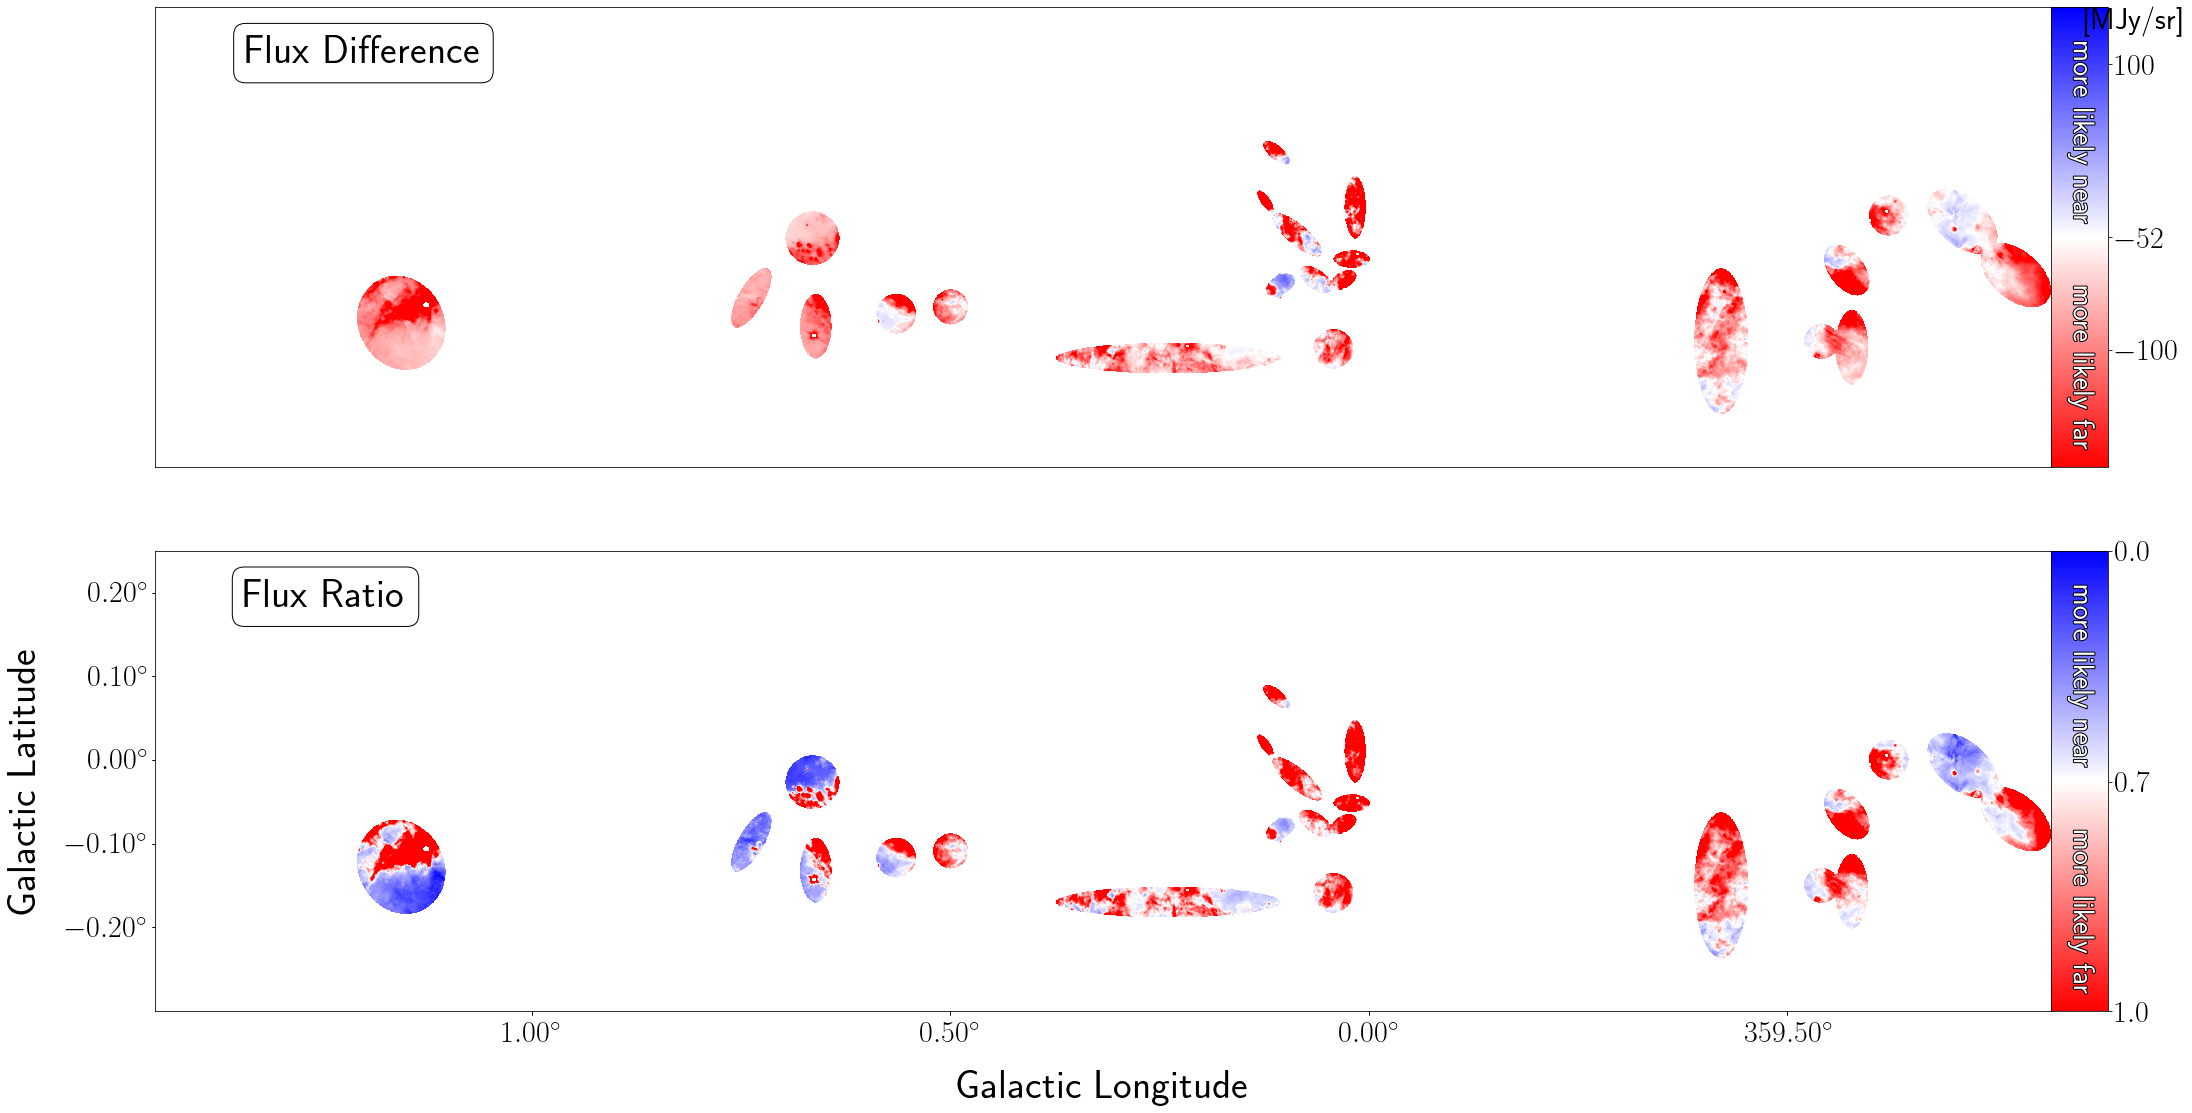

In [144]:
regions = Regions.read('Terrier_2018_all.reg', format='ds9')

# Dictionary of contour names and their region indices
contours = {
    'MC1': 0, 'MC2': 1, 'Br1': 2, 'Br2': 3, 'G0.11-0.11': 4, 'Arches': 5, 'DX': 6,
    'Fil. 2011': 7, 'G0.04-0.16': 8, 'G0.02+0.01': 9, 'G0.09-0.02': 10, 'G0.24-0.17': 11,
    'Sgr B': 12, 'Sgr B2': 13, 'G0.74-0.11': 14, 'G0.66-0.13': 15, 'G0.50-0.11': 16,
    'G0.56-0.11': 17, 'Sgr C': 18, 'C1': 19, 'C2': 20, 'C3': 21, 'C4': 22, 'M359.38-0.00': 23,
    'M359.23-0.04a': 24, 'M359.23-0.04b': 25, 'Sgr D core': 26
}

# Create a dictionary of contour names and their corresponding regions
#cloud_dict = {name: regions[index] for name, index in contours.items()}

# Specify the names of the regions you want to use

selected_region_names=list(contours.keys()) #for thse entire list of clouds in contours
# Create a filtered dictionary for the selected regions
selected_region_names=['MC1', 'MC2','Br1', 'Br2', 'Arches', 'DX',
    'Fil. 2011', 'G0.04-0.16', 'G0.02+0.01', 'G0.09-0.02', 'G0.24-0.17',
    'Sgr B2', 'G0.74-0.11', 'G0.66-0.13', 'G0.50-0.11',
    'G0.56-0.11', 'C1', 'C2', 'C3', 'C4', 'M359.38-0.00',
    'M359.23-0.04a', 'M359.23-0.04b', 'Sgr D core']
#selected_region_names =['MC1','MC2','Br1','Br2']
#sub_dict = {name: cloud_dict[name] for name in selected_region_names if name in cloud_dict}
sub_dict = {name: regions[contours[name]] for name in selected_region_names if name in contours}
method_instance = methods_8um(sub_dict,selected_region_names)
# Call the flux_calculations method
method_instance.create_flux_maps(unsmoothed_filename='GLM_00000+0000_resid_I4.fits_unsmoothed_cropped.fits', smoothed_filename='8um_smoothed_no_sources.fits')


Mean Difference Scaled: [-1.866166740624985, -1.9357506854865179, -0.27285658764002685, 0.5633952293433842]
Mean Ratio Scaled: [-0.8074363702158378, -0.8626851675770857, -0.2698130384548749, 0.11629707438842773]
[0.021, 0.031, 0.064, 0.106]


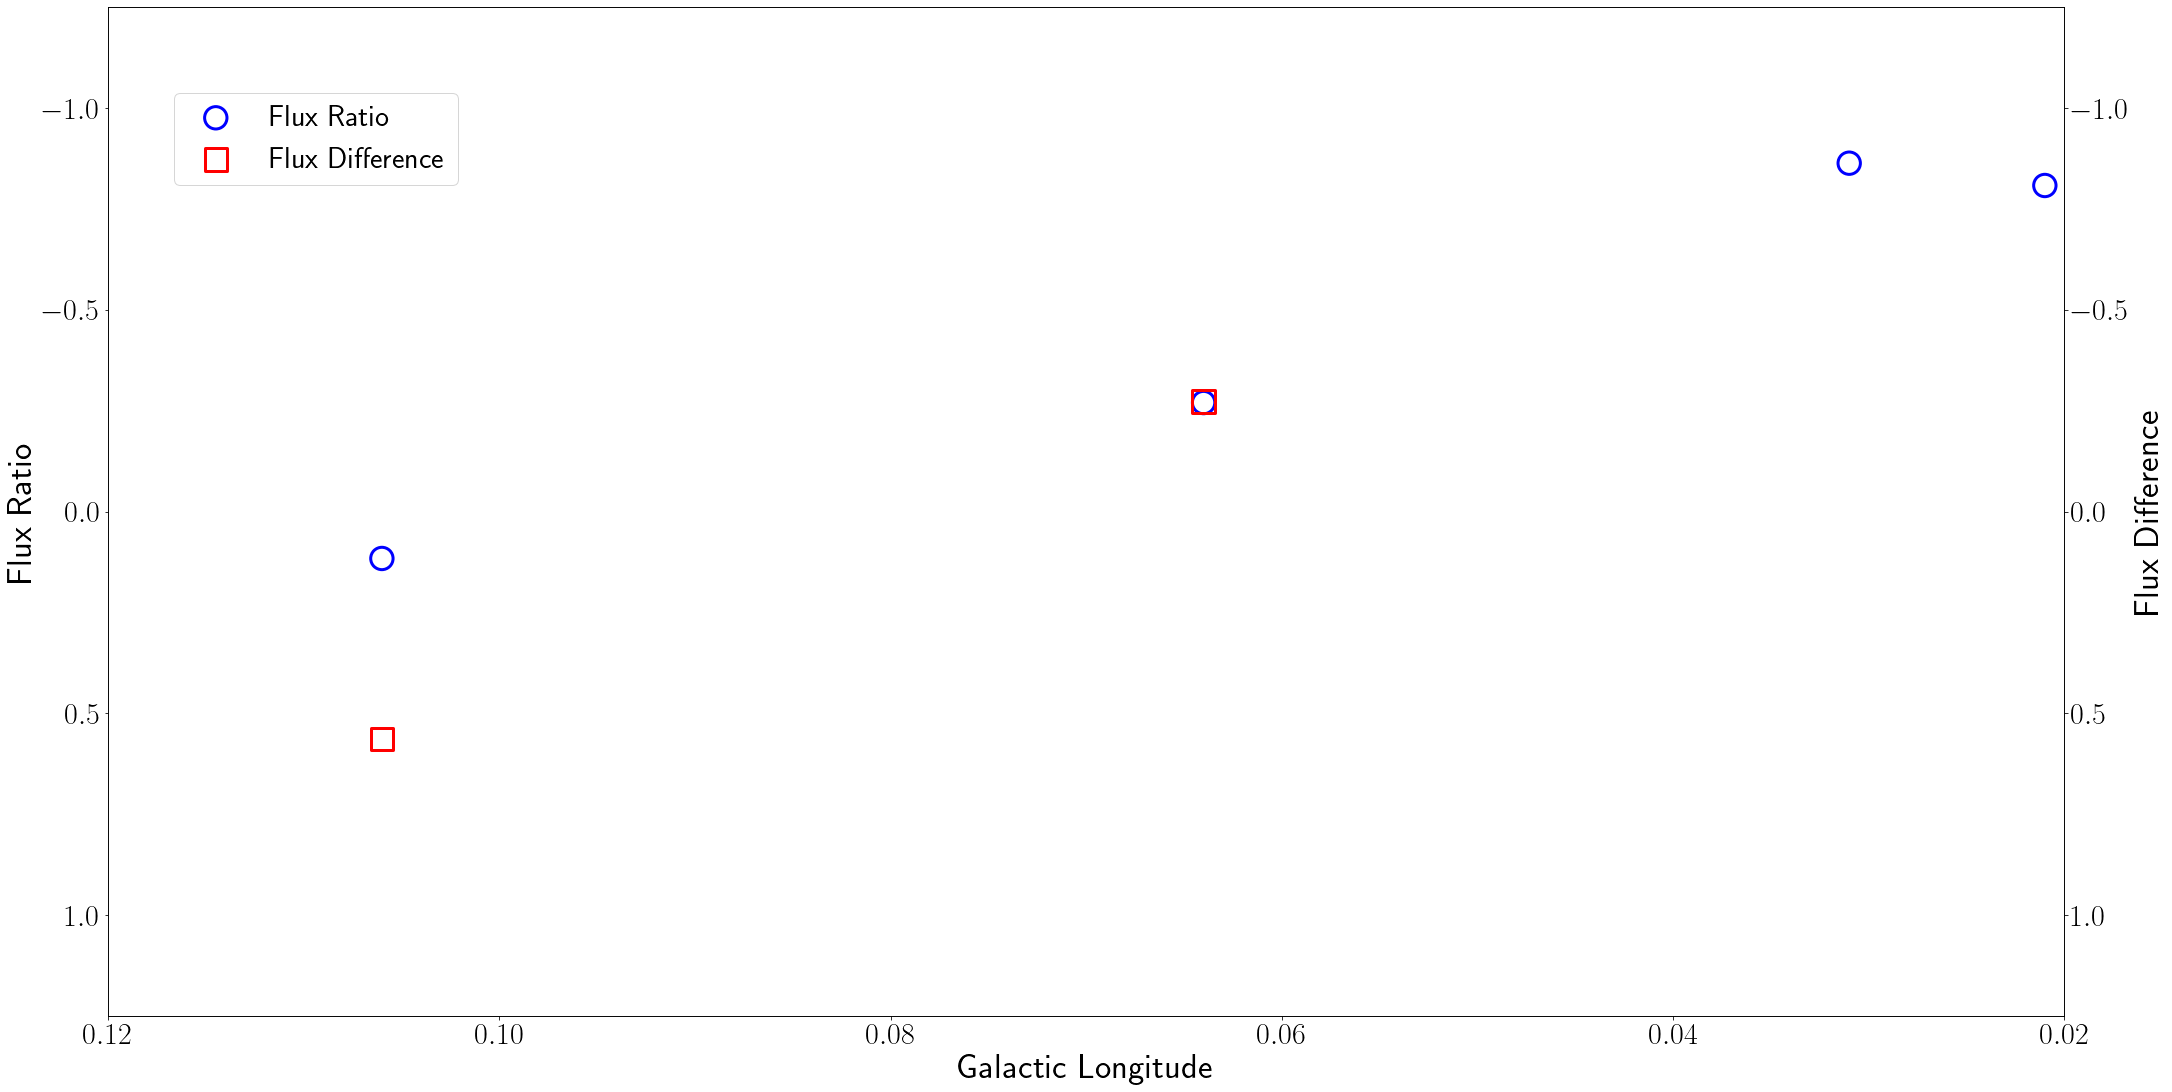

In [143]:
regions = Regions.read('Terrier_2018_all.reg', format='ds9')

# Dictionary of contour names and their region indices
contours = {
    'MC1': 0, 'MC2': 1, 'Br1': 2, 'Br2': 3, 'G0.11-0.11': 4, 'Arches': 5, 'DX': 6,
    'Fil. 2011': 7, 'G0.04-0.16': 8, 'G0.02+0.01': 9, 'G0.09-0.02': 10, 'G0.24-0.17': 11,
    'Sgr B': 12, 'Sgr B2': 13, 'G0.74-0.11': 14, 'G0.66-0.13': 15, 'G0.50-0.11': 16,
    'G0.56-0.11': 17, 'Sgr C': 18, 'C1': 19, 'C2': 20, 'C3': 21, 'C4': 22, 'M359.38-0.00': 23,
    'M359.23-0.04a': 24, 'M359.23-0.04b': 25, 'Sgr D core': 26
}

# Create a dictionary of contour names and their corresponding regions
#cloud_dict = {name: regions[index] for name, index in contours.items()}

# Specify the names of the regions you want to use

selected_region_names=list(contours.keys()) #for thse entire list of clouds in contours
# Create a filtered dictionary for the selected regions
selected_region_names=['MC1', 'MC2','Br1', 'Br2', 'G0.11-0.11', 'Arches', 'DX',
    'Fil. 2011', 'G0.04-0.16', 'G0.02+0.01', 'G0.09-0.02', 'G0.24-0.17',
    'Sgr B2', 'G0.74-0.11', 'G0.66-0.13', 'G0.50-0.11',
    'G0.56-0.11', 'C1', 'C2', 'C3', 'C4', 'M359.38-0.00',
    'M359.23-0.04a', 'M359.23-0.04b', 'Sgr D core']
selected_region_names =['MC1','MC2','Br1','Br2']
#sub_dict = {name: cloud_dict[name] for name in selected_region_names if name in cloud_dict}
sub_dict = {name: regions[contours[name]] for name in selected_region_names if name in contours}
method_instance = methods_8um(sub_dict,selected_region_names)
method_instance.plot_top_down_view(unsmoothed_filename='GLM_00000+0000_resid_I4.fits_unsmoothed_cropped.fits', smoothed_filename='8um_smoothed_no_sources.fits')

In [89]:
print(sub_dict)

{'MC1': <EllipseSkyRegion(center=<SkyCoord (Galactic): (l, b) in deg
    (0.021, -0.052)>, width=168.0 arcsec, height=84.0 arcsec, angle=0.0 deg)>, 'MC2': <EllipseSkyRegion(center=<SkyCoord (Galactic): (l, b) in deg
    (0.031, -0.077)>, width=130.0 arcsec, height=80.0 arcsec, angle=30.0 deg)>, 'Br1': <EllipseSkyRegion(center=<SkyCoord (Galactic): (l, b) in deg
    (0.064, -0.076)>, width=94.0 arcsec, height=174.0 arcsec, angle=55.0 deg)>, 'Br2': <EllipseSkyRegion(center=<SkyCoord (Galactic): (l, b) in deg
    (0.106, -0.083)>, width=146.0 arcsec, height=92.0 arcsec, angle=30.0 deg)>}
